<div class="alert alert-block alert-success">

# Payroll OT Forecasting Models
    
 👨‍🏫 **Jay Kalantar**      
 📅 **[17-July-2023]**
  

</div>

**Objective:**  
My capstone project objective is to leverage Machine Learning Models to improve payroll processes and reduce costs for our clients.  My initial focus is to identify the leading indicators for Overtime work occurrences.

 
**Data Source:**  
My data source will be timecard transactions and the resulting pay calculations.  We also have audit trails that can track the history of the timecard entries and their adjustments.  For privacy reasons, I will use the older transactional data with anonymous user information.

These data require significant feature engineering to calculate the KPIs for the transactions.


**Technique:**  
Depending on the data efficacy, I may be able to develop regression models that can predict the expected Overtime from the leading indicators.  Alternatively, I could classification models that can warn against the occurrence of Overtime preemptively.

I will compare the performance of several models such as Decision Tree, Logistic Regression, and SVM, and perform Grid Search Optimizations with cross-validations.
 

**Expected Results**  
At a minimum, I like to identify and establish any leading indicators of overtime.  The ability to predict overtime would be an additional bonus.


**Why?**  
The blue-collar/hourly operations typically have high labor contents (greater than 70% of P&L) with thin profit margins (less than 3% of P&L).  Therefore, any reduction in labor costs can result in significant profit improvements. Overtimes are typically not anticipated and are the leading cause of cost overruns.

<div class="alert alert-block alert-danger">
    
# Summary 📝
    
* Overtime Prediction
    * EDA with respect to model building
    * Data Prep
    * Model Building
    * Business Insights
    

     
 </div>

<div class="alert alert-block alert-info">

# Import Modules

In [191]:
# Basic packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns # for prettier plots
sns.set()
from pandas import merge

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, precision_score, recall_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.svm import SVR
from sklearn.dummy import DummyClassifier
from sklearn.impute import KNNImputer
from sklearn.model_selection import GridSearchCV
import time
import warnings
warnings.filterwarnings('ignore')

<div class="alert alert-block alert-info">

# Import data

### **Timecards**:  – Employee’s Time IN/OUT with all associated fields (e.g., Emp No, Location, Position, ….)

In [2]:
pp = pd.read_csv('data/PUNCHES_20170101_20170131.zip', compression='zip', header=0, sep='|', quotechar='"')
pp['Date'] = pd.to_datetime(pp['Date'])
pp.shape

(1625730, 47)

In [3]:
pp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1625730 entries, 0 to 1625729
Data columns (total 47 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   BatchCode           4 non-null        object        
 1   Status              1616264 non-null  object        
 2   PeriodStart         1616264 non-null  object        
 3   PeriodEnd           1616264 non-null  object        
 4   PunchID             1625728 non-null  float64       
 5   SiteCode            1625726 non-null  object        
 6   SiteName            1625726 non-null  object        
 7   Category            1625726 non-null  object        
 8   State               1625726 non-null  object        
 9   TimeZone            1625726 non-null  object        
 10  TaskCode            1625726 non-null  object        
 11  TaskName            1625726 non-null  object        
 12  WO_Code             1 non-null        float64       
 13  WO_Desc     

In [4]:
pp.head()

BatchCode Status PeriodStart   PeriodEnd     PunchID SiteCode      SiteName  \
0       NaN   Open  2017-01-01  2017-01-07  89373796.0        0  Do Not Punch   
1       NaN   Open  2017-01-01  2017-01-07  89261015.0        0  Do Not Punch   
2       NaN   Open  2017-01-01  2017-01-07  89145281.0        0  Do Not Punch   
3       NaN    NaN         NaN         NaN  90335419.0        0  Do Not Punch   
4       NaN   Open  2017-01-01  2017-01-07  89318481.0        0  Do Not Punch   

            Category State TimeZone  ... PTOType              CreatedDate  \
0  Do Not Punch [01]    PA      EST  ...     0.0  2017-01-07 07:38:08.590   
1  Do Not Punch [01]    PA      EST  ...     0.0  2017-01-05 07:09:39.477   
2  Do Not Punch [01]    PA      EST  ...     0.0  2017-01-03 07:02:26.197   
3  Do Not Punch [01]    PA      EST  ...     0.0  2017-01-25 10:19:18.990   
4  Do Not Punch [01]    PA      EST  ...     0.0  2017-01-06 07:18:15.523   

   Created By             ModifiedDate Modified By Notes          TSID  \
0         2G6  2017-01-07 08:17:10.907         2G6   NaN  5.470097e+07   
1         NaN  2017-01-05 14:19:22.713         NaN   NaN  5.464538e+07   
2         NaN  2017-01-03 15:19:54.773         NaN   NaN  5.457646e+07   
3         J63  2017-01-25 10:19:28.937         J63   NaN  1.881367e+15   
4         NaN  2017-01-06 14:18:44.600         NaN   NaN  5.468454e+07   

  TimesheetID   EmployeeID  EmployerID  
0   1872020.0  988060943.0    227999.0  
1   1872020.0  988062047.0    227999.0  
2   1872020.0  988062047.0    227999.0  
3         NaN  988063199.0    227999.0  
4   1872020.0  988062047.0    227999.0  

[5 rows x 47 columns]

### **Timesheets**:  Employee's calculated pay (e.g., REG Pay, Overtime Pay, Expenses, … )


In [5]:
# Import Timesheets
ts = pd.read_csv('data/TIMESHEETS_20170101_20170131.zip', compression='zip', header=0, sep='|', quotechar='"')
ts['Date'] = pd.to_datetime(ts['Date'])
ts.shape

(1023102, 32)

In [6]:
ts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1023102 entries, 0 to 1023101
Data columns (total 32 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   BatchCode           2 non-null        object        
 1   Status              1023100 non-null  object        
 2   PeriodStart         1023100 non-null  object        
 3   PeriodEnd           1023100 non-null  object        
 4   SiteCode            1023100 non-null  object        
 5   SiteName            1023100 non-null  object        
 6   Category            1023100 non-null  object        
 7   State               1023100 non-null  object        
 8   TimeZone            1023100 non-null  object        
 9   TaskCode            1023100 non-null  object        
 10  TaskName            1023100 non-null  object        
 11  WO_Code             0 non-null        float64       
 12  WO_Desc             0 non-null        float64       
 13  PayrollID   

In [7]:
ts.head()

BatchCode    Status PeriodStart   PeriodEnd SiteCode      SiteName  \
0       NaN  Approved  2017-01-29  2017-02-04        0  Do Not Punch   
1       NaN  Approved  2017-01-29  2017-02-04        0  Do Not Punch   
2       NaN      Open  2017-01-01  2017-01-07        0  Do Not Punch   
3       NaN      Open  2017-01-01  2017-01-07        0  Do Not Punch   
4       NaN      Open  2017-01-01  2017-01-07        0  Do Not Punch   

            Category State TimeZone TaskCode  ... RateMultiplier  PTOType  \
0  Do Not Punch [01]    PA      EST     TA01  ...            1.0      0.0   
1  Do Not Punch [01]    PA      EST     TA01  ...            1.0      0.0   
2  Do Not Punch [01]    PA      EST     TA01  ...            1.0      0.0   
3  Do Not Punch [01]    PA      EST     TA01  ...            1.0      0.0   
4  Do Not Punch [01]    PA      EST     TA01  ...            1.0      0.0   

   Rate Base Rate Rate Chng By Rate Chng Date  TimesheetID        TSID  \
0   0.0       NaN          NaN            NaN    1881638.0  55527979.0   
1   0.0       NaN          NaN            NaN    1881638.0  55489224.0   
2   0.0       NaN          NaN            NaN    1872020.0  54684544.0   
3   0.0       NaN          NaN            NaN    1872020.0  54576459.0   
4   0.0       NaN          NaN            NaN    1872020.0  54608931.0   

    EmployeeID EmployerID  
0  988062047.0   227999.0  
1  988062047.0   227999.0  
2  988062047.0   227999.0  
3  988062047.0   227999.0  
4  988062047.0   227999.0  

[5 rows x 32 columns]

### **Correction Lags**:  List of punch correction lag times in hours for any modified punch

In [8]:
cl = pd.read_csv('data/CORRECTION_LAGS_20170101_20170131.zip', compression='zip', header=0, sep='|', quotechar='"')
cl['Date'] = pd.to_datetime(cl['Date'])
cl.shape

(565851, 29)

In [9]:
cl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 565851 entries, 0 to 565850
Data columns (total 29 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   BatchCode      2 non-null       object        
 1   Status         559941 non-null  object        
 2   PeriodStart    559941 non-null  object        
 3   PeriodEnd      559941 non-null  object        
 4   PunchID        565849 non-null  float64       
 5   SiteCode       565849 non-null  object        
 6   SiteName       565849 non-null  object        
 7   Category       565849 non-null  object        
 8   TaskCode       565849 non-null  object        
 9   TaskName       565849 non-null  object        
 10  WO_Code        0 non-null       float64       
 11  WO_Desc        0 non-null       float64       
 12  PayrollID      565849 non-null  object        
 13  Employee       565849 non-null  object        
 14  Date           565849 non-null  datetime64[ns]
 15  

In [10]:
cl.head()

BatchCode    Status              PeriodStart                PeriodEnd  \
0       NaN  Approved  2017-01-22 00:00:00.000  2017-02-04 00:00:00.000   
1       NaN  Approved  2017-01-22 00:00:00.000  2017-02-04 00:00:00.000   
2       NaN  Approved  2016-12-25 00:00:00.000  2017-01-07 00:00:00.000   
3       NaN  Approved  2017-01-22 00:00:00.000  2017-02-04 00:00:00.000   
4       NaN  Approved  2016-12-25 00:00:00.000  2017-01-07 00:00:00.000   

      PunchID SiteCode                        SiteName Category TaskCode  \
0  90551037.0      00B  H LAKEWOOD NURSING CENTER-HSKP       BB   LGTHSK   
1  90455849.0      00B  H LAKEWOOD NURSING CENTER-HSKP       BB   LGTHSK   
2  89132628.0      00B  H LAKEWOOD NURSING CENTER-HSKP       BB   LGTHSK   
3  90181043.0      00B  H LAKEWOOD NURSING CENTER-HSKP       BB   LGTHSK   
4  89302874.0      00B  H LAKEWOOD NURSING CENTER-HSKP       BB     HHFT   

               TaskName  ...             Final TimeIN  \
0     Light Housekeeper  ...  2017-01-29 05:55:45.000   
1     Light Housekeeper  ...  2017-01-27 07:28:07.000   
2     Light Housekeeper  ...  2017-01-02 12:34:37.000   
3     Light Housekeeper  ...  2017-01-22 12:30:15.000   
4  Hvy Hspr / FloorTech  ...  2017-01-05 11:57:03.000   

             Final TimeOUT Corr Lag Hrs IN Chng By             IN Chng Date  \
0  2017-01-29 11:56:31.000         22.0     R06402  2017-01-30 02:44:19.343   
1  2017-01-27 12:27:26.000          6.0     R06402  2017-01-27 12:31:02.613   
2  2017-01-02 18:29:45.000         27.0     R06402  2017-01-03 14:24:27.550   
3  2017-01-22 14:29:37.000          8.0     X02950  2017-01-22 19:34:23.393   
4  2017-01-05 13:00:35.000          9.0     R06402  2017-01-05 19:13:56.867   

  OUT Chng By            OUT Chng Date     Hours Rate Chng Min  
0      R06402  2017-01-30 02:44:19.343  6.016666  8.1      NaN  
1      R06402  2017-01-27 12:31:02.613  4.983333  8.1      NaN  
2      R06402  2017-01-03 14:24:27.550  5.916666  8.1      NaN  
3      X02950  2017-01-22 19:34:23.393  1.983333  8.1      NaN  
4         NaN                      NaN  1.050000  8.1      NaN  

[5 rows x 29 columns]

<div class="alert alert-block alert-info">

# Feature Engineering

### **<font color= darkcyan> Count Punches from from Timecards </font>**

In [11]:
pp_clean =pp.groupby(['SiteCode','PayrollID','TaskCode','Date']).agg({'PunchID':'count'})
pp_clean = pd.DataFrame(pp_clean.to_records())
pp_clean.rename(columns={'PunchID':'PunchCount'}, inplace=True)
pp_clean.head()

SiteCode PayrollID TaskCode       Date  PunchCount
0        0       2G6     TA01 2017-01-04           1
1        0       2G6     TA01 2017-01-07           1
2        0       6HG     TA01 2017-01-03           1
3        0       6HG     TA01 2017-01-04           1
4        0       6HG     TA01 2017-01-05           1

In [12]:
pp_clean.shape

(910995, 5)

### **<font color= darkcyan> Create %OT KPI calculation from Timesheets </font>**

In [13]:
ts2 =ts.groupby(['SiteCode','PayrollID','TaskCode','Date','RateMultiplier']).agg({'Hours':'sum'})
# Flatten ts2
ts2 = pd.DataFrame(ts2.to_records())
ts2.head()

SiteCode PayrollID TaskCode       Date  RateMultiplier  Hours
0        0       2G6     TA01 2017-01-07             1.0   0.50
1        0       6HG     TA01 2017-01-03             1.0   8.25
2        0       6HG     TA01 2017-01-04             1.0   7.25
3        0       6HG     TA01 2017-01-05             1.0   7.00
4        0       6HG     TA01 2017-01-06             1.0   7.00

In [14]:
ts3=ts2[ts2['RateMultiplier'] == 1.0]
# Renmae the column $Gross to Gross
ts3.rename(columns={'Hours':'REG_Hours'}, inplace=True)
ts3.head()

SiteCode PayrollID TaskCode       Date  RateMultiplier  REG_Hours
0        0       2G6     TA01 2017-01-07             1.0       0.50
1        0       6HG     TA01 2017-01-03             1.0       8.25
2        0       6HG     TA01 2017-01-04             1.0       7.25
3        0       6HG     TA01 2017-01-05             1.0       7.00
4        0       6HG     TA01 2017-01-06             1.0       7.00

In [15]:
ts4=ts2[ts2['RateMultiplier'] > 1.0].groupby(['SiteCode','PayrollID','TaskCode','Date']).sum()
# drop column 'RateMultiplier'
ts4.drop('RateMultiplier', axis=1, inplace=True)
ts4.rename(columns={'Hours':'OT_Hours'}, inplace=True)
ts4.reset_index(inplace=True)
ts4.head()

SiteCode PayrollID TaskCode       Date  OT_Hours
0      00B    D17598   LGTHSK 2017-01-01     12.00
1      00B    R06402   ACTMGR 2017-01-13      7.00
2      00B    R06402   ACTMGR 2017-01-20      9.75
3      00B    R06402   ACTMGR 2017-01-27     11.50
4      00G    C00902  HOUSEKG 2017-01-01      5.50

In [16]:
ts_clean = merge(ts3, ts4, on=['SiteCode','PayrollID','TaskCode','Date'], how='left')
ts_clean.drop('RateMultiplier', axis=1, inplace=True)
ts_clean.fillna(0, inplace=True)
ts_clean['%OT'] = ts_clean['OT_Hours'] / (ts_clean['REG_Hours'] + ts_clean['OT_Hours'])
ts_clean.drop('OT_Hours', axis=1, inplace=True)
ts_clean.head()

SiteCode PayrollID TaskCode       Date  REG_Hours  %OT
0        0       2G6     TA01 2017-01-07       0.50  0.0
1        0       6HG     TA01 2017-01-03       8.25  0.0
2        0       6HG     TA01 2017-01-04       7.25  0.0
3        0       6HG     TA01 2017-01-05       7.00  0.0
4        0       6HG     TA01 2017-01-06       7.00  0.0

In [17]:
ts_clean.shape

(890404, 6)

### **<font color= darkcyan> Calculate Correction Counts and Lag Hours from Correction Lags </font>**

In [18]:
cl['Correction'].value_counts()

Miss Punch      512415
Open Punch       50307
Time Changed      3127
Name: Correction, dtype: int64

In [19]:
cl2 = pd.pivot_table(cl, values='Corr Lag Hrs', index=('SiteCode','PayrollID','TaskCode','Date'), columns='Correction', aggfunc='count')
cl2 = pd.DataFrame(cl2.to_records())
cl2.fillna(0, inplace=True)
cl2.head()

SiteCode PayrollID TaskCode       Date  Miss Punch  Open Punch  Time Changed
0      00B    A10899   LGTHSK 2017-01-04         2.0         0.0           0.0
1      00B    A10899   LGTHSK 2017-01-05         2.0         0.0           0.0
2      00B    A10899   LGTHSK 2017-01-06         2.0         0.0           0.0
3      00B    A10899   LGTHSK 2017-01-07         2.0         0.0           0.0
4      00B    A10899   LGTHSK 2017-01-08         2.0         0.0           0.0

In [20]:
cl3 = pd.pivot_table(cl, values='Corr Lag Hrs', index=('SiteCode','PayrollID','TaskCode','Date'), columns='Correction', aggfunc='sum')
cl3 = pd.DataFrame(cl3.to_records())
cl3.fillna(0, inplace=True)
cl3.head()

SiteCode PayrollID TaskCode       Date  Miss Punch  Open Punch  Time Changed
0      00B    A10899   LGTHSK 2017-01-04        31.0         0.0           0.0
1      00B    A10899   LGTHSK 2017-01-05        23.0         0.0           0.0
2      00B    A10899   LGTHSK 2017-01-06         7.0         0.0           0.0
3      00B    A10899   LGTHSK 2017-01-07        25.0         0.0           0.0
4      00B    A10899   LGTHSK 2017-01-08        55.0         0.0           0.0

In [21]:
cl_clean = merge(cl2, cl3, on=['SiteCode','PayrollID','TaskCode','Date'], how='inner')
cl_clean = cl_clean.fillna(0)
cl_clean.head()

SiteCode PayrollID TaskCode       Date  Miss Punch_x  Open Punch_x  \
0      00B    A10899   LGTHSK 2017-01-04           2.0           0.0   
1      00B    A10899   LGTHSK 2017-01-05           2.0           0.0   
2      00B    A10899   LGTHSK 2017-01-06           2.0           0.0   
3      00B    A10899   LGTHSK 2017-01-07           2.0           0.0   
4      00B    A10899   LGTHSK 2017-01-08           2.0           0.0   

   Time Changed_x  Miss Punch_y  Open Punch_y  Time Changed_y  
0             0.0          31.0           0.0             0.0  
1             0.0          23.0           0.0             0.0  
2             0.0           7.0           0.0             0.0  
3             0.0          25.0           0.0             0.0  
4             0.0          55.0           0.0             0.0

In [22]:
cl_clean.shape

(346705, 10)

### **<font color= darkcyan> Combine Punches and Correction lags </font>**

In [23]:
df = merge(pp_clean, cl_clean, on=['SiteCode','PayrollID','TaskCode','Date'], how='left')
df = df.fillna(0)
df.head()

SiteCode PayrollID TaskCode       Date  PunchCount  Miss Punch_x  \
0        0       2G6     TA01 2017-01-04           1           0.0   
1        0       2G6     TA01 2017-01-07           1           0.0   
2        0       6HG     TA01 2017-01-03           1           0.0   
3        0       6HG     TA01 2017-01-04           1           0.0   
4        0       6HG     TA01 2017-01-05           1           0.0   

   Open Punch_x  Time Changed_x  Miss Punch_y  Open Punch_y  Time Changed_y  
0           0.0             0.0           0.0           0.0             0.0  
1           0.0             0.0           0.0           0.0             0.0  
2           0.0             0.0           0.0           0.0             0.0  
3           0.0             0.0           0.0           0.0             0.0  
4           0.0             0.0           0.0           0.0             0.0

In [24]:
# Add % touch KPIs
df['%Miss_Punch'] = df['Miss Punch_x']/df['PunchCount']
df['%Open_Punch'] = df['Open Punch_x']/df['PunchCount']
df['%Time_Changed'] = df['Time Changed_x']/df['PunchCount']
# drop the old columns
df.drop('Miss Punch_x', axis=1, inplace=True)
df.drop('Open Punch_x', axis=1, inplace=True)
df.drop('Time Changed_x', axis=1, inplace=True)
# Rename Columns
df.rename(columns={'Miss Punch_y':'Corr_Lag_Hr_Miss_Punch'}, inplace=True)
df.rename(columns={'Open Punch_y':'Corr_Lag_Hr_Open_Punch'}, inplace=True)
df.rename(columns={'Time Changed_y':'Corr_Lag_Hr_Time_Changed'}, inplace=True)
df = df.fillna(0)
df.head()

SiteCode PayrollID TaskCode       Date  PunchCount  Corr_Lag_Hr_Miss_Punch  \
0        0       2G6     TA01 2017-01-04           1                     0.0   
1        0       2G6     TA01 2017-01-07           1                     0.0   
2        0       6HG     TA01 2017-01-03           1                     0.0   
3        0       6HG     TA01 2017-01-04           1                     0.0   
4        0       6HG     TA01 2017-01-05           1                     0.0   

   Corr_Lag_Hr_Open_Punch  Corr_Lag_Hr_Time_Changed  %Miss_Punch  %Open_Punch  \
0                     0.0                       0.0          0.0          0.0   
1                     0.0                       0.0          0.0          0.0   
2                     0.0                       0.0          0.0          0.0   
3                     0.0                       0.0          0.0          0.0   
4                     0.0                       0.0          0.0          0.0   

   %Time_Changed  
0            0.0  
1            0.0  
2            0.0  
3            0.0  
4            0.0

### **<font color= darkcyan> Combine with Timesheet Data </font>**

In [25]:
df = merge(df, ts_clean, on=['SiteCode','PayrollID','TaskCode','Date'], how='inner')
df['dayofweek'] = pd.to_datetime(df['Date']).dt.dayofweek
df.head()

SiteCode PayrollID TaskCode       Date  PunchCount  Corr_Lag_Hr_Miss_Punch  \
0        0       2G6     TA01 2017-01-07           1                     0.0   
1        0       6HG     TA01 2017-01-03           1                     0.0   
2        0       6HG     TA01 2017-01-04           1                     0.0   
3        0       6HG     TA01 2017-01-05           1                     0.0   
4        0       6HG     TA01 2017-01-06           1                     0.0   

   Corr_Lag_Hr_Open_Punch  Corr_Lag_Hr_Time_Changed  %Miss_Punch  %Open_Punch  \
0                     0.0                       0.0          0.0          0.0   
1                     0.0                       0.0          0.0          0.0   
2                     0.0                       0.0          0.0          0.0   
3                     0.0                       0.0          0.0          0.0   
4                     0.0                       0.0          0.0          0.0   

   %Time_Changed  REG_Hours  %OT  dayofweek  
0            0.0       0.50  0.0          5  
1            0.0       8.25  0.0          1  
2            0.0       7.25  0.0          2  
3            0.0       7.00  0.0          3  
4            0.0       7.00  0.0          4

<div class="alert alert-block alert-info">

# Exploratory Data Analysis (EDA)

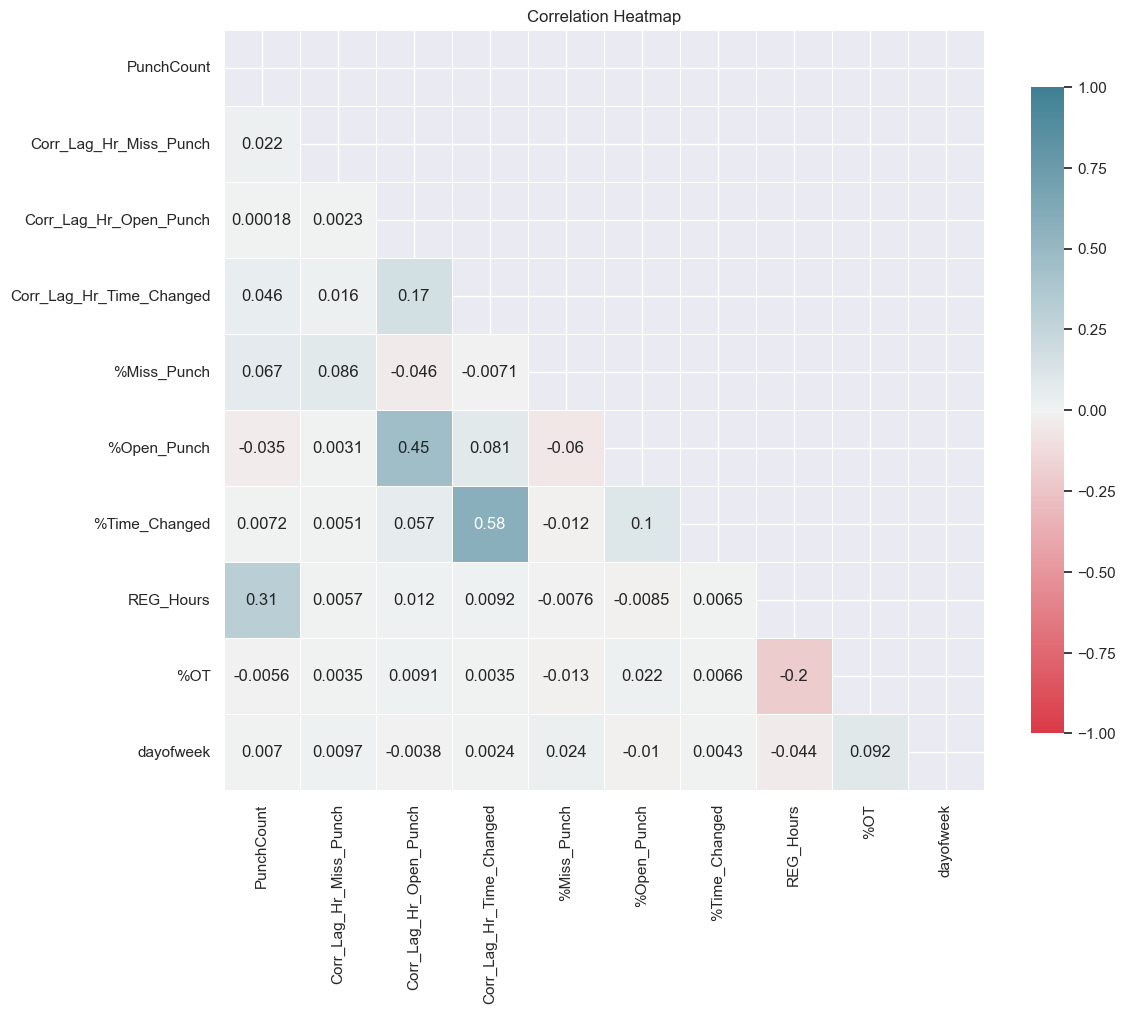

In [26]:
# Plot heatmap of correlations
plt.figure(figsize = (12,12), tight_layout = True)
plt.title('Correlation Heatmap', fontsize = 12)
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(10, 220, as_cmap=True)

sns.heatmap(corr, 
            cmap = cmap, 
            mask = mask, 
            center = 0, 
            vmax = 1, 
            vmin = -1, 
            square = True, 
            linewidths = 0.5, 
            cbar_kws={"shrink": 0.6},
            annot = True,
)
plt.show();

## Position Analysis

In [ ]:
# Value counnt positions
ts_clean['TaskCode'].value_counts()

LGTHSK                  187297
HOUSEKG                 175623
DTAID                   117871
LNDWRK                  102522
ACTMGR                   76370
HHFT                     70059
COOK                     65511
PLWRK                    38070
DIETARY                  30331
MIT                      11012
RGDIET                    7828
ASTAM                     5891
DTTECH                     637
MAINT                      343
ARMGR                      252
COOK w/ SHIFT DIFF         138
MNTWRK                     117
TA01                        99
DIETARY PM                  91
Laundry                     70
DIETARY AM                  58
Aide Cook                   50
Late Hskp                   43
DRVR                        28
PM Cook                     28
REGDIET                     25
COOK w/ DIFFERENTIAL        13
Cook w/ Differential        12
dietician                    8
consultant                   6
dietic                       1
Name: TaskCode, dtype: int64

In [28]:
### Summerized data
df_mean = pd.DataFrame(df.groupby(['SiteCode','PayrollID','TaskCode']).mean().to_records())
df_sum = pd.DataFrame(df.groupby(['SiteCode','PayrollID','TaskCode']).sum().to_records())

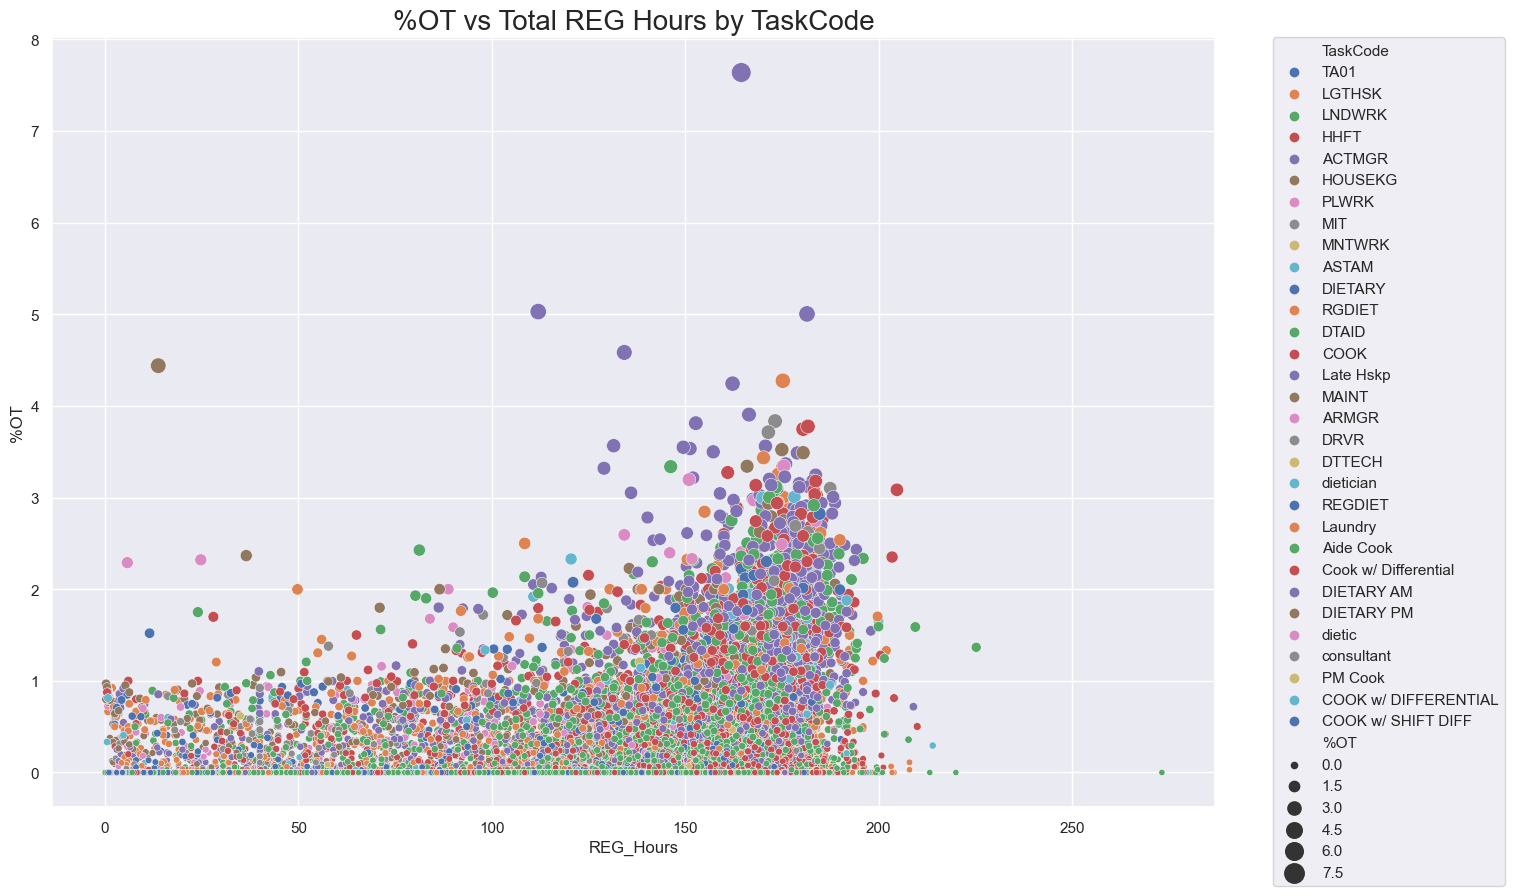

In [ ]:
#Plot %OT vs Total REG Hours by TaskCode
plt.figure(figsize=(15,10))
sns.scatterplot(data=df_sum, x="REG_Hours", y="%OT", palette="deep", hue="TaskCode", size="%OT", sizes=(20, 200), legend=True)
# sns.scatterplot(data=ts5.groupby(['SiteCode','PayrollID','TaskCode']).sum(), x="REG Hours", y="OT Hours", palette="deep", hue="TaskCode", size="OT Hours", sizes=(20, 200), legend=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title('%OT vs Total REG Hours by TaskCode', fontsize=20);

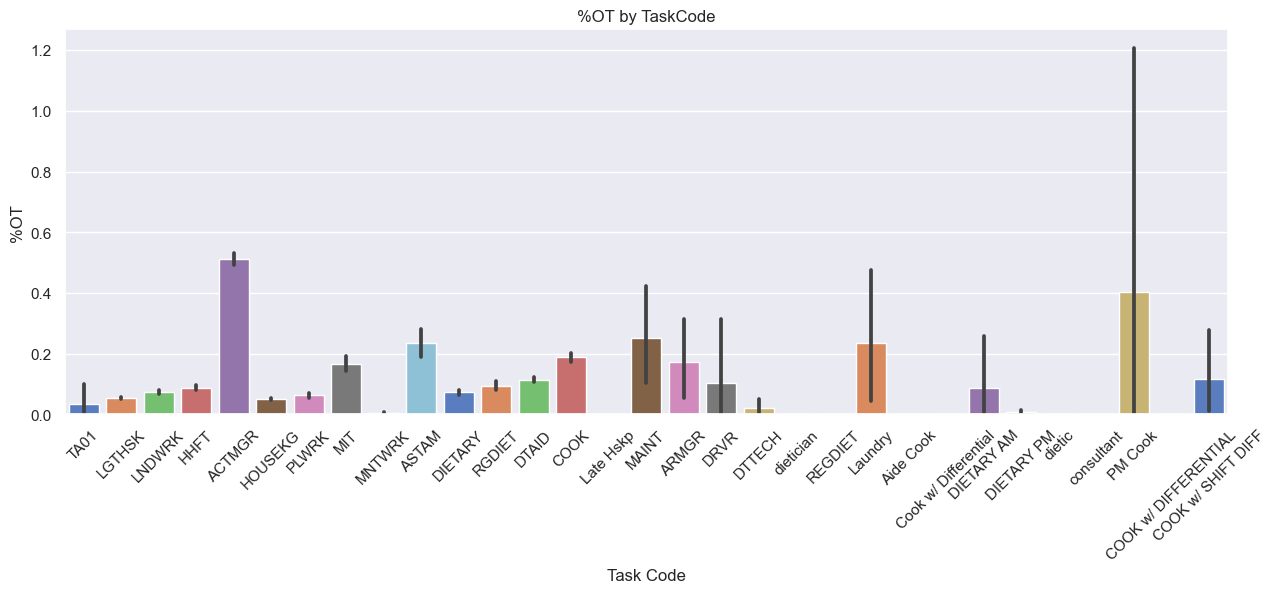

In [ ]:
# Plot %OT by Position
plt.figure(figsize=(15,5))
sns.barplot(x='TaskCode', y='%OT', data=df_sum, palette='muted')
plt.title('%OT by TaskCode')
plt.xlabel('Task Code')
plt.xticks(rotation=45)
plt.ylabel('%OT')
plt.show();

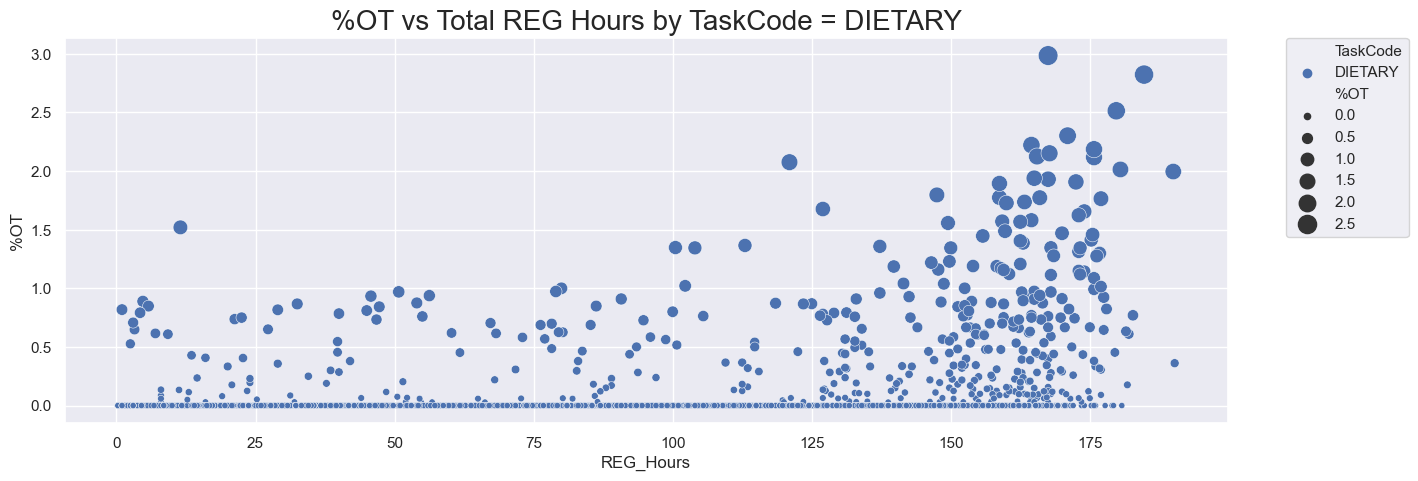

In [29]:
# Plot %OT vs Total REG Hours by TaskCode = DIETARY
plt.figure(figsize=(15,5))
sns.scatterplot(data=df_sum[df_sum['TaskCode'] == 'DIETARY'], x="REG_Hours", y="%OT", palette="deep", hue="TaskCode", size="%OT", sizes=(20, 200), legend=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title('%OT vs Total REG Hours by TaskCode = DIETARY', fontsize=20);

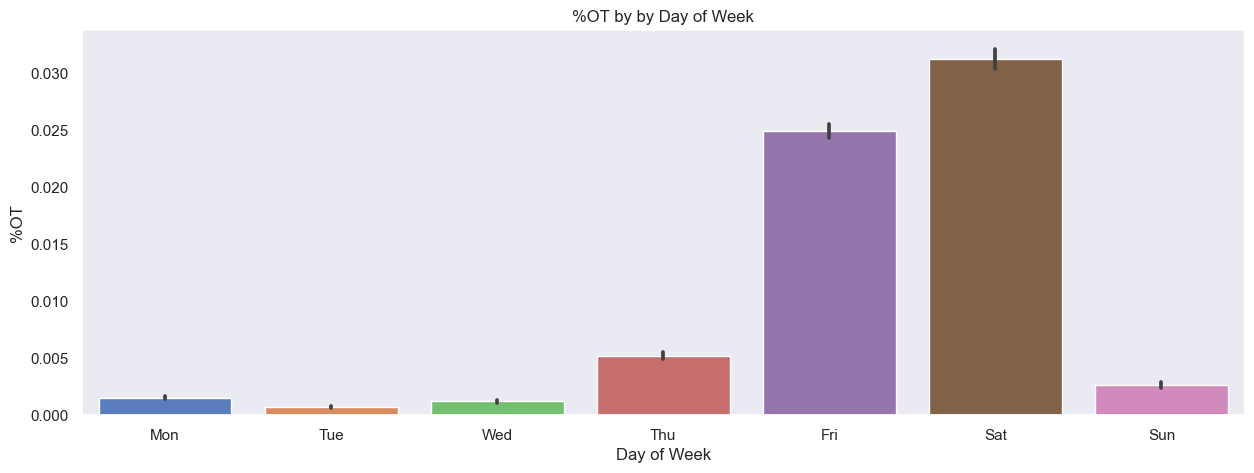

In [ ]:
# Plot %OT by DOW
plt.figure(figsize=(15,5))
sns.barplot(x='dayofweek', y='%OT', data=df, palette='muted')
plt.xticks(np.arange(7), ('Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'))
plt.title('%OT by by Day of Week')
plt.xlabel('Day of Week')
# plt.xticks(rotation=45)
plt.ylabel('%OT')
plt.grid(axis='y');

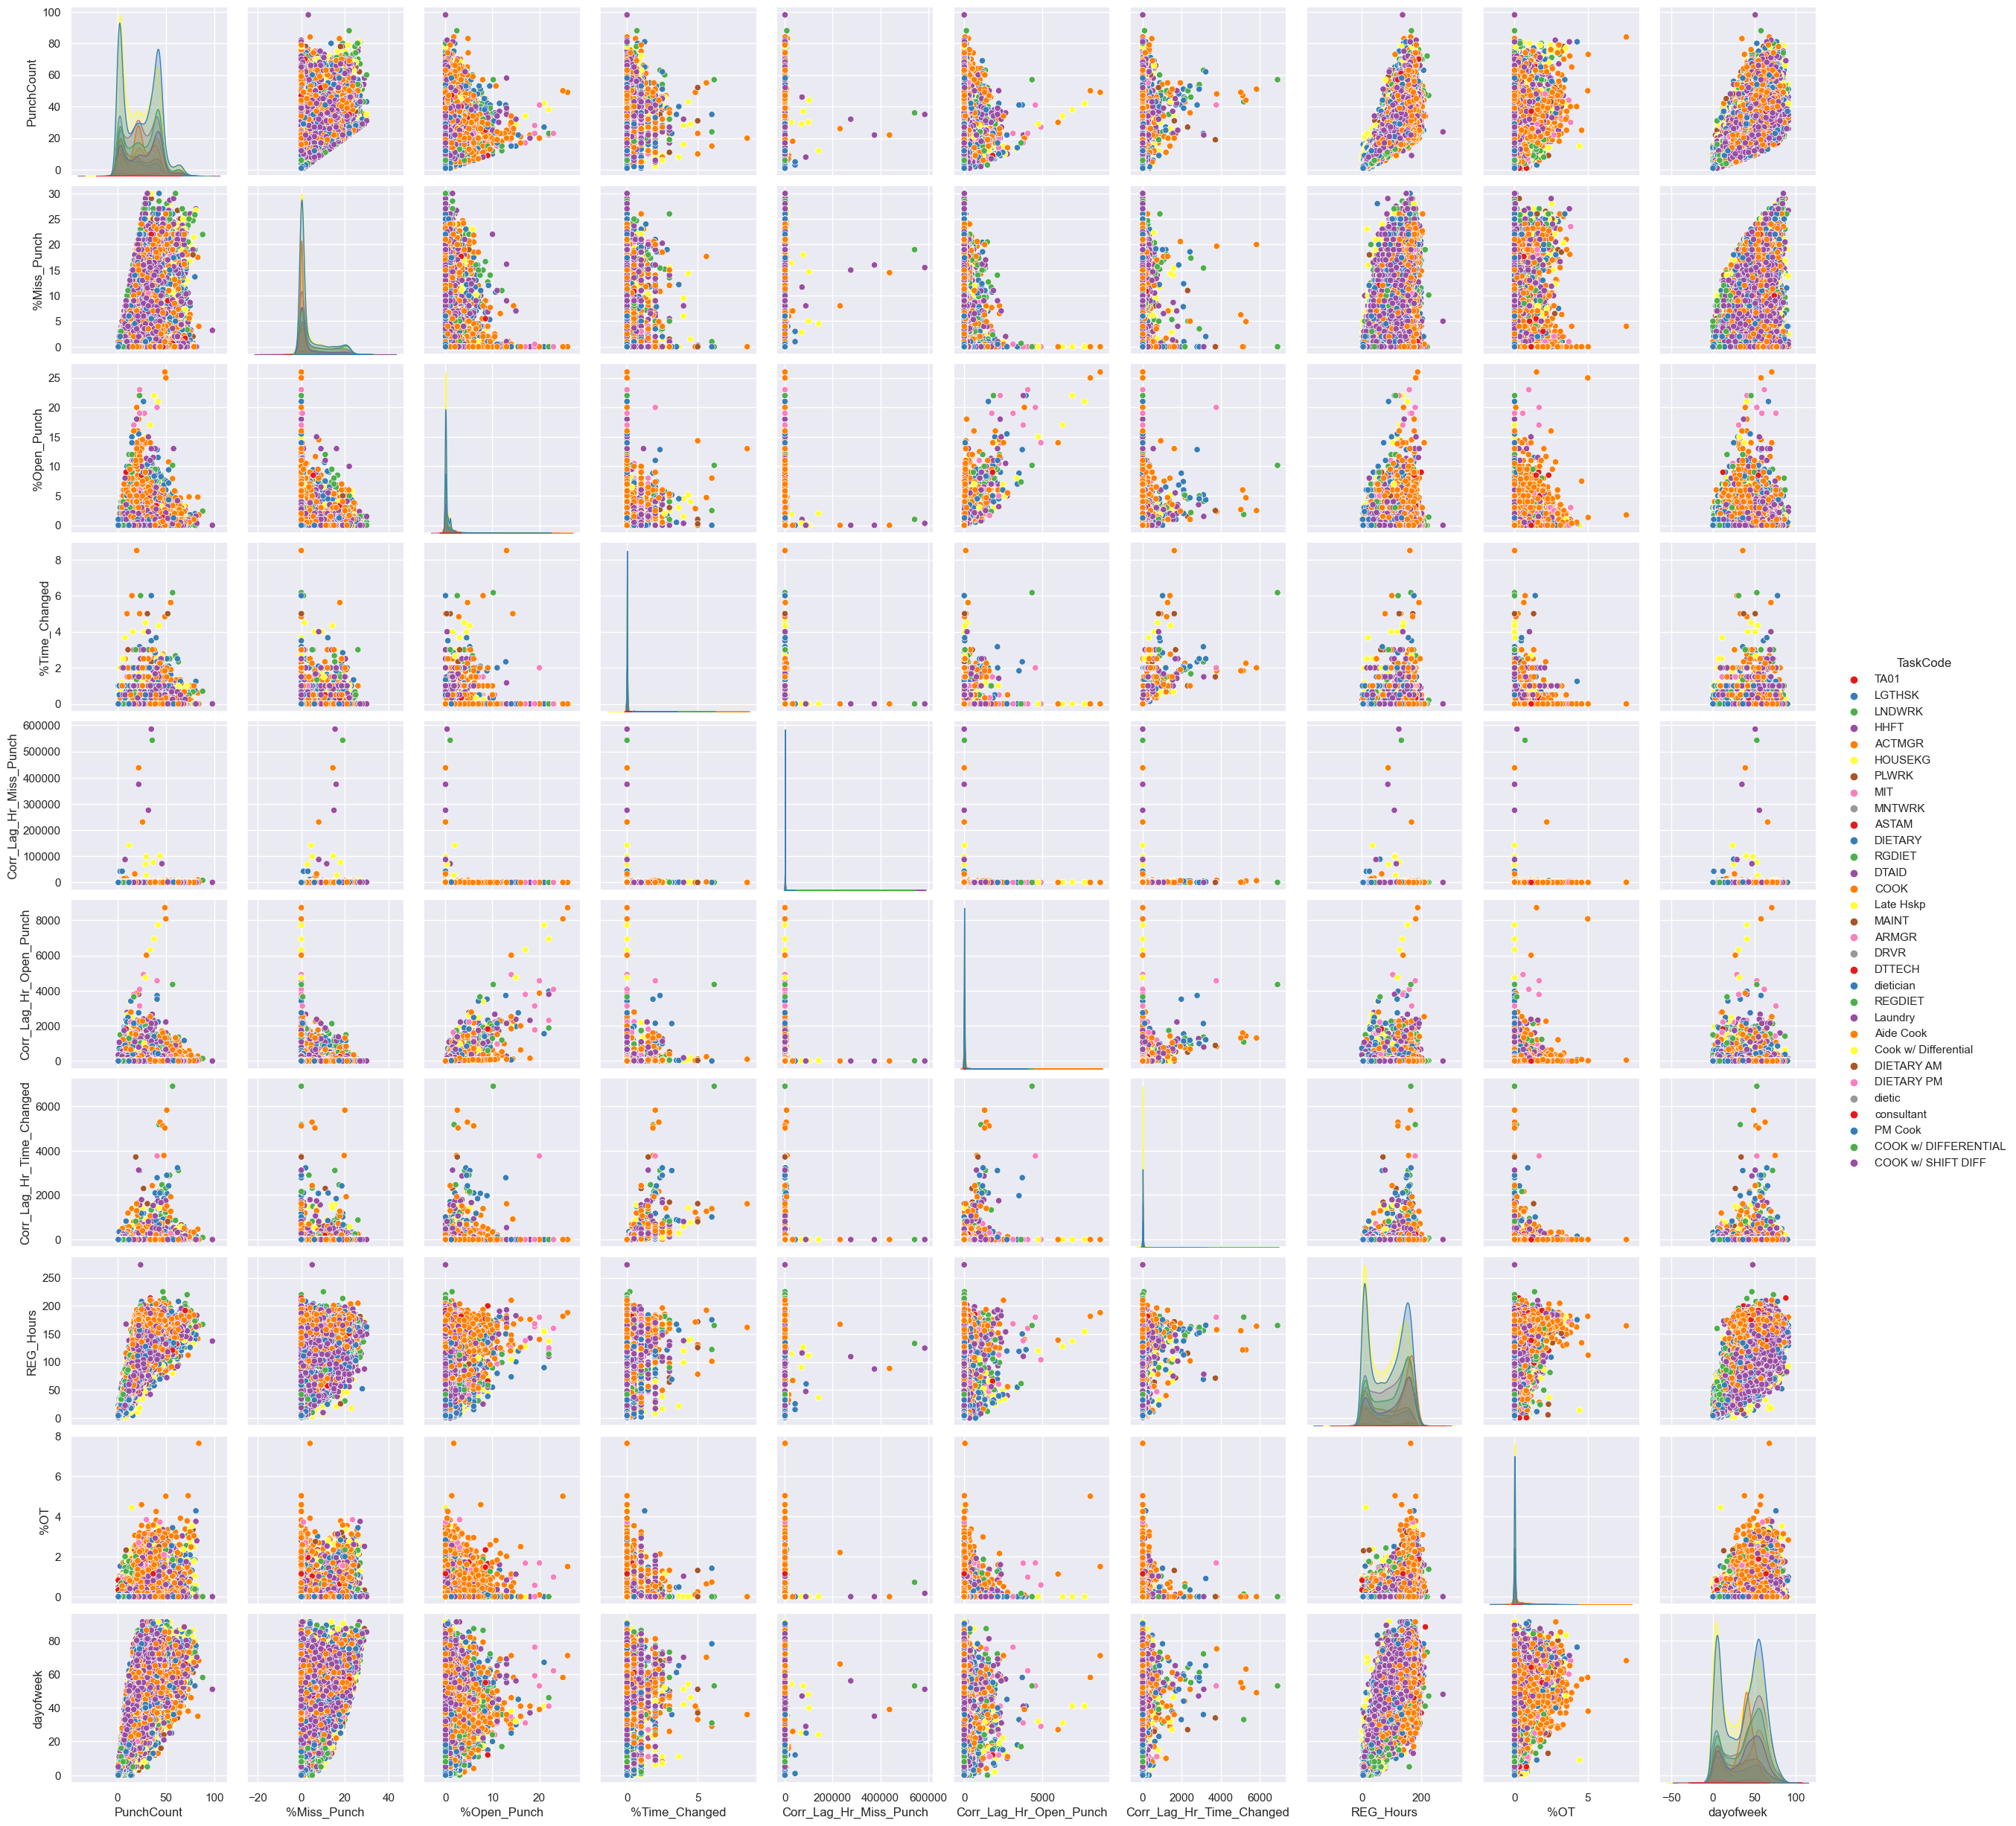

In [ ]:
sns.pairplot(df_sum, hue='TaskCode', palette='Set1');

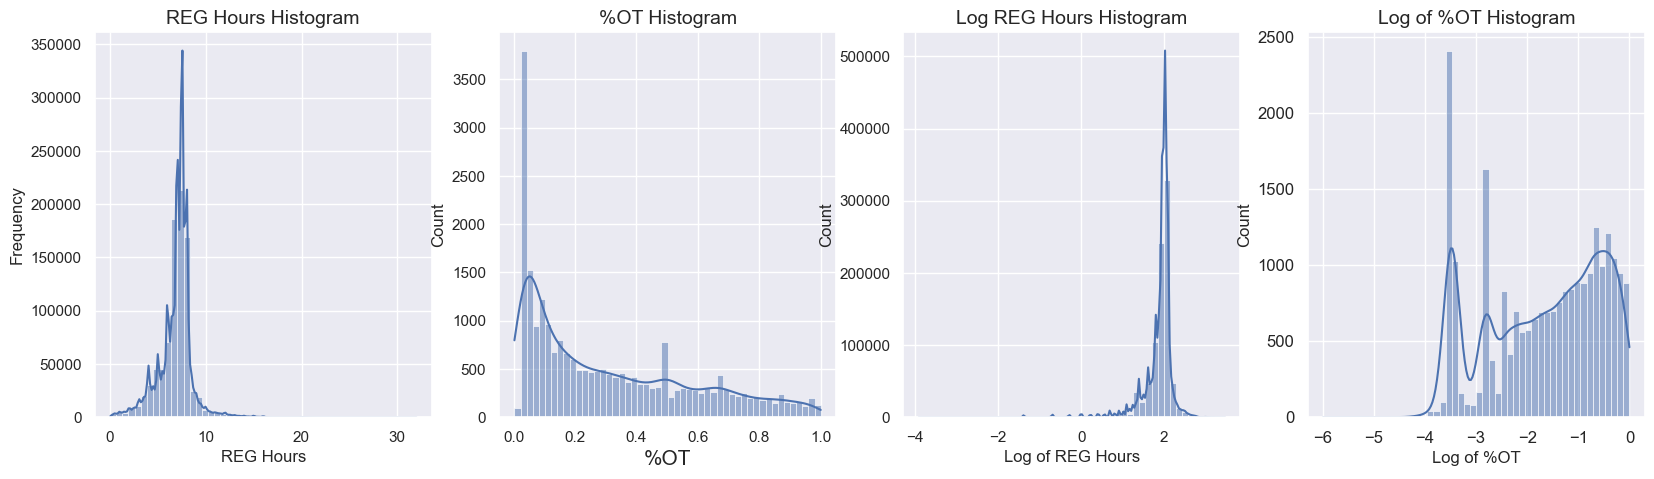

In [ ]:
# show 2x2 plots of REG_Hours, %OT, Log REG_Hours, Log %OT
plt.figure(figsize = (20, 5))
plt.subplot(1, 4, 1)
sns.histplot(df['REG_Hours'], bins = 50, kde = True)
plt.title('REG Hours Histogram', fontsize = 14)
plt.xlabel('REG Hours', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)
plt.subplot(1, 4, 2)
sns.histplot(df['%OT'][df['%OT'] > 0], bins = 50, kde = True)
plt.title('%OT Histogram', fontsize = 14)
plt.xlabel('%OT', fontsize = 15)
# plt.ylabel('Frequency', fontsize = 12)
plt.subplot(1, 4, 3)
sns.histplot(np.log(df['REG_Hours']), bins = 50, kde = True)
plt.title('Log REG Hours Histogram', fontsize = 14)
plt.xlabel('Log of REG Hours', fontsize = 12)
# plt.ylabel('Frequency', fontsize = 1)
plt.subplot(1, 4, 4)
sns.histplot(np.log(df['%OT'][df['%OT'] > 0]), bins = 50, kde = True)
plt.title('Log of %OT Histogram', fontsize = 14)
plt.xlabel('Log of %OT', fontsize = 12)
# plt.ylabel('Frequency', fontsize = 12)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12);

<div class="alert alert-block alert-info">

## Regression Modeling

### Feature Selection

In [30]:
df_clean = df.copy()

# df_clean['dayofweek'] = pd.to_datetime(df_clean['Date']).dt.dayofweek
df_clean.drop('SiteCode', axis=1, inplace=True)
df_clean.drop('PayrollID', axis=1, inplace=True)
# df_clean.drop('TaskCode', axis=1, inplace=True)
df_clean.drop('Date', axis=1, inplace=True)
# df_clean.drop('dayofweek', axis=1, inplace=True)
df_clean.drop('PunchCount', axis=1, inplace=True)
# Replace Nan with 0
df_clean.fillna(0, inplace=True)
# Convert day of week to categorical variable
df_clean['dayofweek'] = df_clean['dayofweek'].astype('category')

In [31]:
object_cols = list(df_clean.select_dtypes(include=['object']).columns)
object_cols

['TaskCode']

In [32]:
# Encode categorical variables
df_clean = pd.get_dummies(df_clean, columns=object_cols, drop_first=True)
df_clean.head()

Corr_Lag_Hr_Miss_Punch  Corr_Lag_Hr_Open_Punch  Corr_Lag_Hr_Time_Changed  \
0                     0.0                     0.0                       0.0   
1                     0.0                     0.0                       0.0   
2                     0.0                     0.0                       0.0   
3                     0.0                     0.0                       0.0   
4                     0.0                     0.0                       0.0   

   %Miss_Punch  %Open_Punch  %Time_Changed  REG_Hours  %OT dayofweek  \
0          0.0          0.0            0.0       0.50  0.0         5   
1          0.0          0.0            0.0       8.25  0.0         1   
2          0.0          0.0            0.0       7.25  0.0         2   
3          0.0          0.0            0.0       7.00  0.0         3   
4          0.0          0.0            0.0       7.00  0.0         4   

   TaskCode_ARMGR  ...  TaskCode_MIT  TaskCode_MNTWRK  TaskCode_PLWRK  \
0               0  ...             0                0               0   
1               0  ...             0                0               0   
2               0  ...             0                0               0   
3               0  ...             0                0               0   
4               0  ...             0                0               0   

   TaskCode_PM Cook  TaskCode_REGDIET  TaskCode_RGDIET  TaskCode_TA01  \
0                 0                 0                0              1   
1                 0                 0                0              1   
2                 0                 0                0              1   
3                 0                 0                0              1   
4                 0                 0                0              1   

   TaskCode_consultant  TaskCode_dietic  TaskCode_dietician  
0                    0                0                   0  
1                    0                0                   0  
2                    0                0                   0  
3                    0                0                   0  
4                    0                0                   0  

[5 rows x 39 columns]

### Train/Test Split

In [33]:
# Split data into X and y
X = df_clean.drop('%OT', axis=1)
y = df_clean['%OT']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)

print("\n")

print("X_test: ", X_test.shape)
print("y_test: ", y_test.shape)

X_train:  (619945, 38)
y_train:  (619945,)


X_test:  (265692, 38)
y_test:  (265692,)


### Scale Data

In [34]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 885637 entries, 0 to 885636
Data columns (total 38 columns):
 #   Column                         Non-Null Count   Dtype   
---  ------                         --------------   -----   
 0   Corr_Lag_Hr_Miss_Punch         885637 non-null  float64 
 1   Corr_Lag_Hr_Open_Punch         885637 non-null  float64 
 2   Corr_Lag_Hr_Time_Changed       885637 non-null  float64 
 3   %Miss_Punch                    885637 non-null  float64 
 4   %Open_Punch                    885637 non-null  float64 
 5   %Time_Changed                  885637 non-null  float64 
 6   REG_Hours                      885637 non-null  float64 
 7   dayofweek                      885637 non-null  category
 8   TaskCode_ARMGR                 885637 non-null  uint8   
 9   TaskCode_ASTAM                 885637 non-null  uint8   
 10  TaskCode_Aide Cook             885637 non-null  uint8   
 11  TaskCode_COOK                  885637 non-null  uint8   
 12  TaskCode_COOK w/

In [36]:
# Identify columns to be scaled
numerical_columns = [col for col in X.columns if X[col].dtype in ['int64', 'float64','category']]

# Scale the data using StandardScaler and update the X_train and X_test dataframes
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_test_scaled[numerical_columns] = scaler.transform(X_test[numerical_columns])

In [37]:
# Scaled data looks good we copy the scaled data back to X_train and X_test
X_train = X_train_scaled.copy()
X_test = X_test_scaled.copy()

Here are some of the regression algorithms that can be used for feature importance prediction:

* Linear Regression
* Polynomial Regression
* Ridge Regression
* Lasso Regression
* Elastic Net Regression
* Support Vector Regression (SVR)
* Decision Tree Regression
* Random Forest Regression
* Gradient Boosting Regression

**We are choosing these regressors to determine feature importance**

In [65]:
# Create and measure the mse for each model
scores_reg = pd.DataFrame(columns=['model', 'MSE', 'R2 Score', 'Time to Train (sec)'])

models = [
    ('Linear Regression', LinearRegression()),
    # ('Polynomial Regression', PolynomialFeatures(degree=2)),
    ('Ridge Regression', Ridge()),    
    ('Lasso Regression', Lasso()),
    ('ElasticNet Regression', ElasticNet()),
    # ('SVM Regression', SVR()),   # Stopped after 180 minutes
    ('Decision Tree Regression', DecisionTreeRegressor()),
    ('Random Forest Regression', RandomForestRegressor()),
    ('Gradient Boosting Regression', GradientBoostingRegressor()),
]

for name, model in models:
    start = time.time()
    model.fit(X_train, y_train)
    end = time.time()
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    score = model.score(X_test, y_test)
    t = end - start
    # scores.loc[len(scores)] = [model.__class__.__name__, score, t]
    scores.loc[len(scores)] = [model.__class__.__name__, mse, score, t]
    print(f'{model.__class__.__name__}')
    print ('---------------------------------------------------')
    print(f'MSE: {mse:.4f}')
    print(f'R2 Score: {score:.4f}')
    print(f'Time to train: {end - start:.2f} seconds')
    print('\n')

LinearRegression
---------------------------------------------------
MSE: 0.0041
R2 Score: 0.0722
Time to train: 4.40 seconds


Ridge
---------------------------------------------------
MSE: 0.0041
R2 Score: 0.0722
Time to train: 0.77 seconds


Lasso
---------------------------------------------------
MSE: 0.0044
R2 Score: -0.0000
Time to train: 1.12 seconds


ElasticNet
---------------------------------------------------
MSE: 0.0044
R2 Score: -0.0000
Time to train: 1.07 seconds


DecisionTreeRegressor
---------------------------------------------------
MSE: 0.0033
R2 Score: 0.2419
Time to train: 9.75 seconds


RandomForestRegressor
---------------------------------------------------
MSE: 0.0028
R2 Score: 0.3671
Time to train: 692.72 seconds


GradientBoostingRegressor
---------------------------------------------------
MSE: 0.0030
R2 Score: 0.3017
Time to train: 309.75 seconds




In [66]:
scores.head(10)

model       MSE  R2 Score  Time to Train (sec)
0           LinearRegression  0.004052  0.072224             4.399659
1                      Ridge  0.004052  0.072226             0.768916
2                      Lasso  0.004367 -0.000012             1.118071
3                 ElasticNet  0.004367 -0.000012             1.074952
4      DecisionTreeRegressor  0.003311  0.241872             9.753447
5      RandomForestRegressor  0.002764  0.367056           692.722771
6  GradientBoostingRegressor  0.003049  0.301714           309.750895

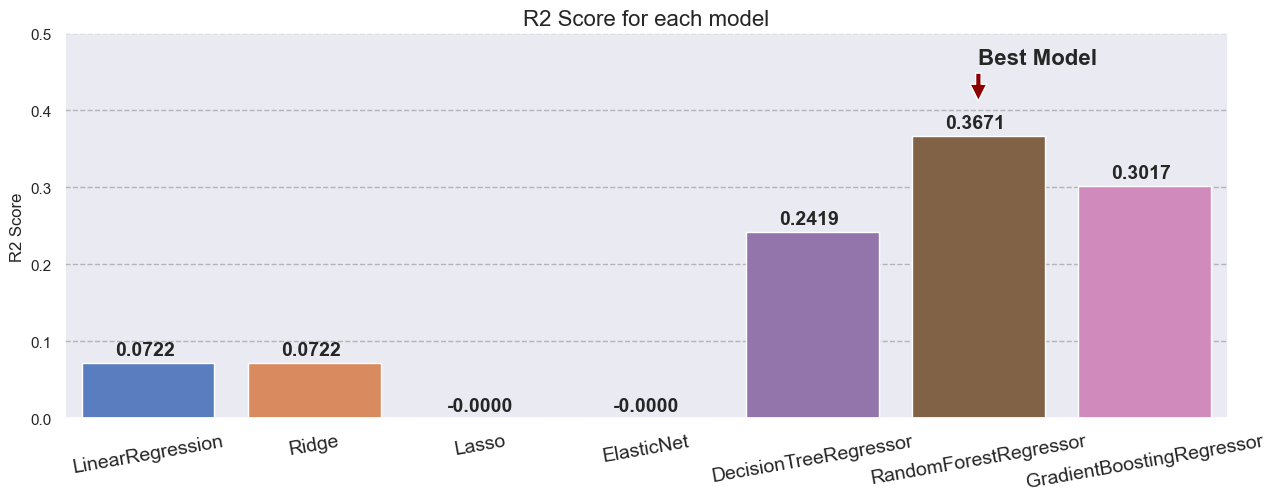

In [136]:
# Plot R2
plt.figure(figsize=(15, 5))
sns.barplot(x='model', y='R2 Score', data=scores, palette='muted')
plt.ylabel('R2 Score')
plt.title('R2 Score for each model', fontsize=16)
# hide x axis header
plt.xlabel('')
plt.xticks(rotation=10, fontsize=14)
plt.ylim(0, 0.5)
grid = plt.grid(axis='y', linestyle='--', alpha=0.5, color = 'gray')
# show values on top of bars
for i, v in enumerate(scores['R2 Score']):
    plt.text(i - 0.2, v + 0.01, f'{v:.4f}', fontsize=14, fontweight='bold')
# Show an arrow pointing to the best model
plt.annotate('Best Model', xy=(5, 0.41), xytext=(5, 0.46), fontsize=16, fontweight='bold', arrowprops=dict(facecolor='darkred', shrink=0.05))
plt.savefig('R2_seaborn.png', dpi=300, bbox_inches='tight');

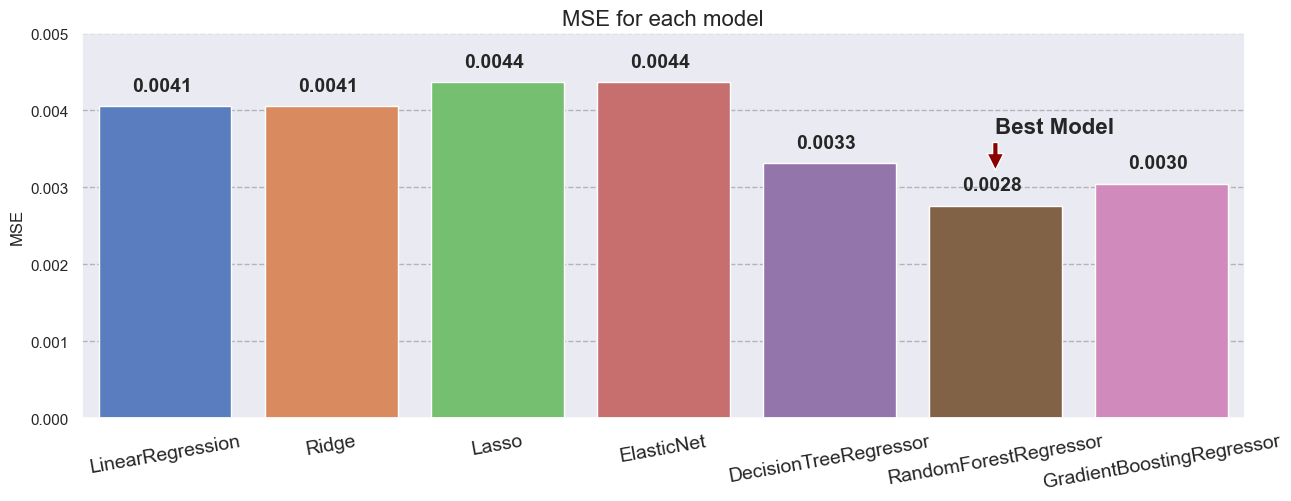

In [135]:
# Plot MSE
plt.figure(figsize=(15, 5))
sns.barplot(x='model', y='MSE', data=scores, palette='muted')
plt.ylabel('MSE')
plt.title('MSE for each model', fontsize=16)
# hide x axis header
plt.xlabel('')
plt.xticks(rotation=10, fontsize=14)
plt.ylim(0, 0.005)
grid = plt.grid(axis='y', linestyle='--', alpha=0.5, color = 'gray')
# show values on top of bars
for i, v in enumerate(scores['MSE']):
    plt.text(i - 0.2, v + 0.0002, f'{v:.4f}', fontsize=14, fontweight='bold')
plt.annotate('Best Model', xy=(5, 0.0032), xytext=(5, 0.0037), fontsize=16, fontweight='bold', arrowprops=dict(facecolor='darkred', shrink=0.05))
plt.savefig('mse_seaborn.png', dpi=300, bbox_inches='tight');

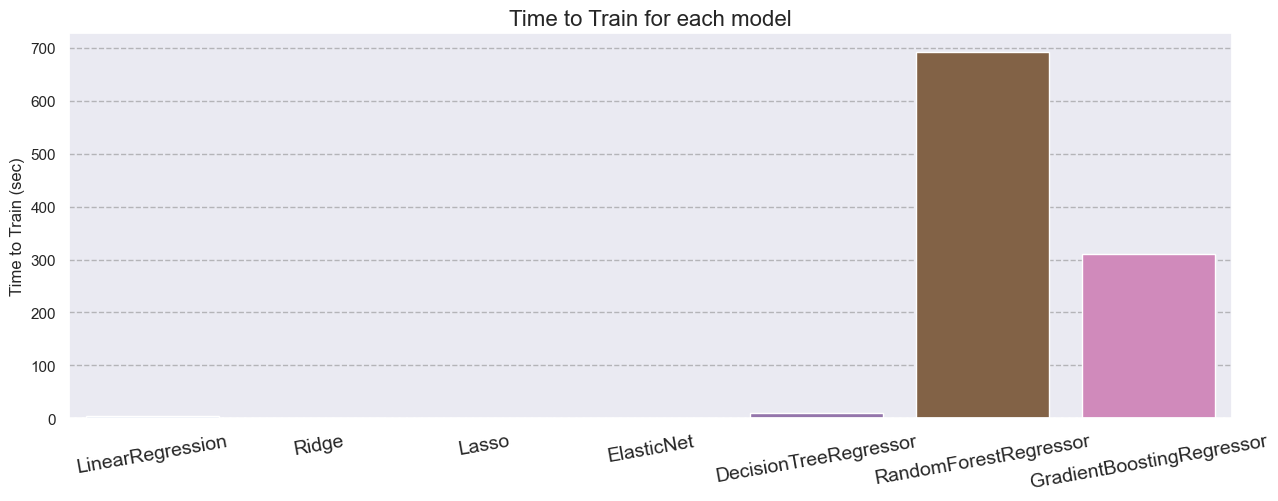

In [118]:
# Plot Time to Train (sec)
plt.figure(figsize=(15, 5))
sns.barplot(x='model', y='Time to Train (sec)', data=scores, palette='muted')
plt.ylabel('Time to Train (sec)')
plt.title('Time to Train for each model', fontsize=16)
# hide x axis header
plt.xlabel('')
plt.xticks(rotation=10, fontsize=14)
# plt.ylim(0, 0.5)
grid = plt.grid(axis='y', linestyle='--', alpha=0.5, color = 'gray')
# show values on top of bars

plt.savefig('Time to Train.png', dpi=300, bbox_inches='tight');

## **<font color= blue> Feature extraction </font>**

In [112]:
# Random Forest Regressor
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print('Random Forest Regressor')
print('R2: ', r2_score(y_test, y_pred_rf))
print('MAE: ', mean_absolute_error(y_test, y_pred_rf))
print('MSE: ', mean_squared_error(y_test, y_pred_rf))
print('RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred_rf)))

Random Forest Regressor
R2:  0.36676842649041497
MAE:  0.010566074284359888
MSE:  0.0027652832004018886
RMSE:  0.052585960107255705


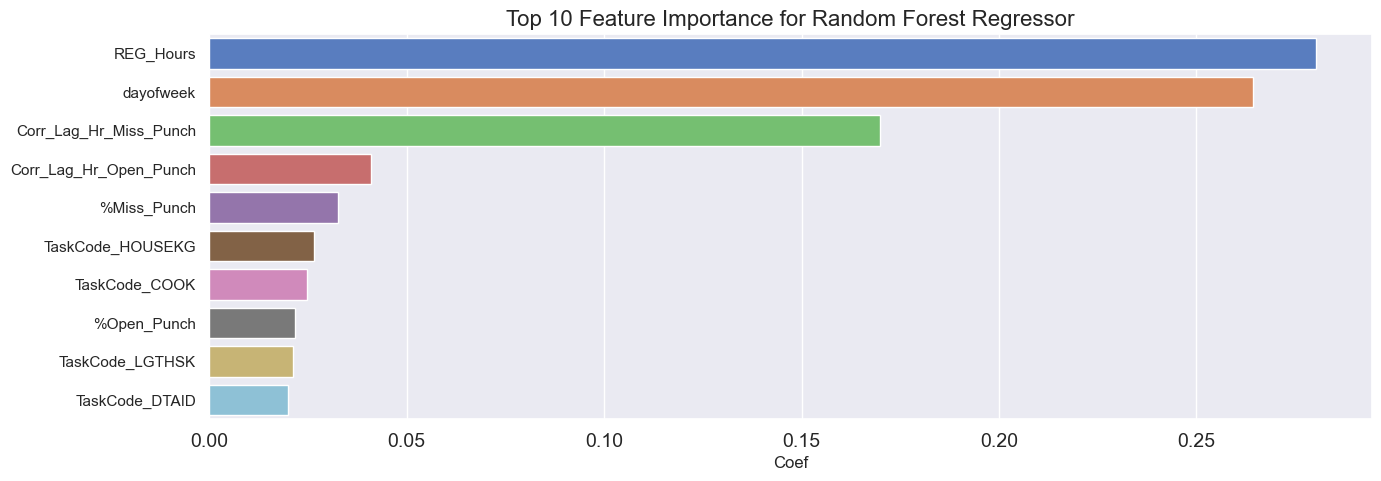

In [133]:
# Plot feature importance of the Random Forest
CC = pd.DataFrame({'Feature': X_train.columns, 'Coef': rf.feature_importances_})
CC = CC.sort_values('Coef', ascending=False)
plt.figure(figsize=(15, 5))
sns.barplot(y='Feature', x='Coef', data=CC.head(10), palette='muted', orient='h')
plt.ylabel('')
plt.title('Top 10 Feature Importance for Random Forest Regressor', fontsize=16)
plt.xticks(rotation=0, fontsize=14)
plt.savefig('Feature Importance.png', dpi=300, bbox_inches='tight');

In [130]:
# Gradient Boosting Regressor
gb = GradientBoostingRegressor(random_state=42)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)
print('Gradient Boosting Regressor')
print('R2: ', r2_score(y_test, y_pred_gb))
print('MAE: ', mean_absolute_error(y_test, y_pred_gb))
print('MSE: ', mean_squared_error(y_test, y_pred_gb))
print('RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred_gb)))

Gradient Boosting Regressor
R2:  0.30171431920409575
MAE:  0.013228755898539947
MSE:  0.0030493704719808654
RMSE:  0.05522110531292239


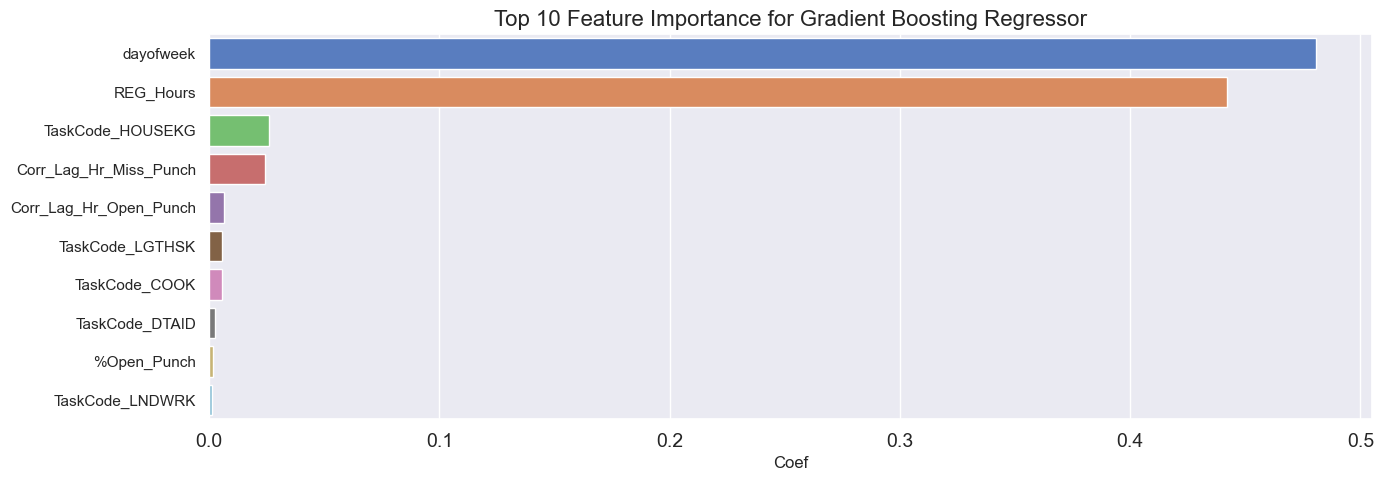

In [132]:
# Plot feature importance of the Gradient Boosting 
CC = pd.DataFrame({'Feature': X_train.columns, 'Coef': gb.feature_importances_})
CC = CC.sort_values('Coef', ascending=False)
plt.figure(figsize=(15, 5))
sns.barplot(y='Feature', x='Coef', data=CC.head(10), palette='muted', orient='h')
plt.ylabel('')
plt.title('Top 10 Feature Importance for Gradient Boosting Regressor', fontsize=16)
plt.xticks(rotation=0, fontsize=14)
plt.savefig('Feature Importance.png', dpi=300, bbox_inches='tight');

<div class="alert alert-info" role="alert">

  # Regression Model Hyperparamters Tuning and Optimization: Gradian Boosting

</div>

In [ ]:
# Hyperparameter tuning for Gradient Boosting Regressor

gb = GradientBoostingRegressor(random_state=42)
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [2, 3, 4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3]
}

grid_search = GridSearchCV(estimator = gb, param_grid = param_grid,
                            cv = 5, n_jobs = -1, verbose = 2)

grid_search.fit(X_train, y_train)

end = time.time()
y_pred = grid_search.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
score = model.score(X_test, y_test)
t = end - start
grid_search.best_params_
print(f'MSE: {mse:.4f}')
print(f'R2 Score: {score:.4f}')
print(f'Time to train: {end - start:.2f} seconds')

<div class="alert alert-warning alert-dismissible fade show" role="alert">
  <strong>Recommendation: </strong> Regression modeling is resulting in week predictions.  Next, we try classification modeling.

</div>

<div class="alert alert-block alert-info">

## Classification Modeling


</div>

###  Convert %OT to 1 or 0

In [139]:
# If y > 0 the 1 else 0
y = np.where(y > 0, 1, 0)

### Train/Test Split

In [140]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)

print("\n")

print("X_test: ", X_test.shape)
print("y_test: ", y_test.shape)

X_train:  (619945, 38)
y_train:  (619945,)


X_test:  (265692, 38)
y_test:  (265692,)


### Based the initial regression results we choose the following classifiers that can provie feature importance as well:

* Dummy Regression
* Decision Tree Regression
* Random Forest Regression
* Gradient Boosting Regression

**We are choosing these regressors to determine feature importance**

In [144]:
# Create and measure the mse for each model
scores = pd.DataFrame(columns=['model', 'Accuracy', 'Precision', 'Recall', 'Time to Train (sec)'])

models = [
    ('Dummy Classifier', DummyClassifier()),
    ('Decision Tree Classifier', DecisionTreeClassifier()),
    ('Random Forest Classifier', RandomForestClassifier()),
    ('Gradient Boosting Classifier', GradientBoostingClassifier()),
]

for name, model in models:
    start = time.time()
    model.fit(X_train, y_train)
    end = time.time()
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    t = end - start
    scores.loc[len(scores)] = [model.__class__.__name__, accuracy, precision, recall, t]
    print(f'{model.__class__.__name__}')
    print ('-----------------------------------------------------')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    print(f'Time to train: {end - start:.2f} seconds')
    print('\n')

DummyClassifier
---------------------------------------------------
Accuracy: 0.9736
Precision: 0.0000
Recall: 0.0000
              precision    recall  f1-score   support

           0       0.97      1.00      0.99    258669
           1       0.00      0.00      0.00      7023

    accuracy                           0.97    265692
   macro avg       0.49      0.50      0.49    265692
weighted avg       0.95      0.97      0.96    265692

[[258669      0]
 [  7023      0]]
Time to train: 0.07 seconds


DecisionTreeClassifier
---------------------------------------------------
Accuracy: 0.9718
Precision: 0.4257
Recall: 0.1921
              precision    recall  f1-score   support

           0       0.98      0.99      0.99    258669
           1       0.43      0.19      0.26      7023

    accuracy                           0.97    265692
   macro avg       0.70      0.59      0.63    265692
weighted avg       0.96      0.97      0.97    265692

[[256849   1820]
 [  5674   1349]]
Tim

#### For our data, then Precision and recall are more useful than accuracy when dealing with imbalanced datasets where one class is much more frequent than the other (i.e. ~3% OT)

#### **Precision** is the ratio of true positives to the sum of true positives and false positives. It measures how many of the predicted positive cases are actually positive. 
#### **Recall** is the ratio of true positives to the sum of true positives and false negatives. It measures how many of the actual positive cases are correctly identified by the model. 
#### **Accuracy** is the ratio of the number of correct predictions to the total number of predictions. It measures how well the model is able to predict both positive and negative cases. 



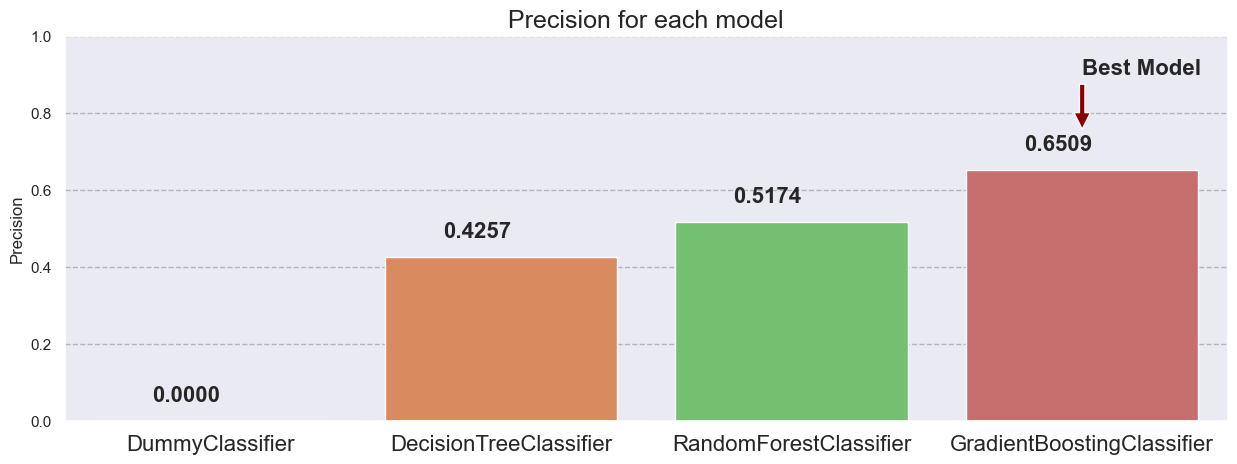

In [158]:
# Plot Precision
plt.figure(figsize=(15, 5))
sns.barplot(x='model', y='Precision', data=scores, palette='muted')
plt.ylabel('Precision')
plt.title('Precision for each model', fontsize=18)
# hide x axis header
plt.xlabel('')
plt.xticks(rotation=0, fontsize=16)
plt.ylim(0, 1)
grid = plt.grid(axis='y', linestyle='--', alpha=0.5, color = 'gray')
# show values on top of bars
for i, v in enumerate(scores['Precision']):
    plt.text(i - 0.2, v + 0.05, f'{v:.4f}', fontsize=16, fontweight='bold')
# Show an arrow pointing to the best model
plt.annotate('Best Model', xy=(3, 0.75), xytext=(3, 0.9), fontsize=16, fontweight='bold', arrowprops=dict(facecolor='darkred', shrink=0.05))
plt.savefig('Precision.png', dpi=300, bbox_inches='tight');

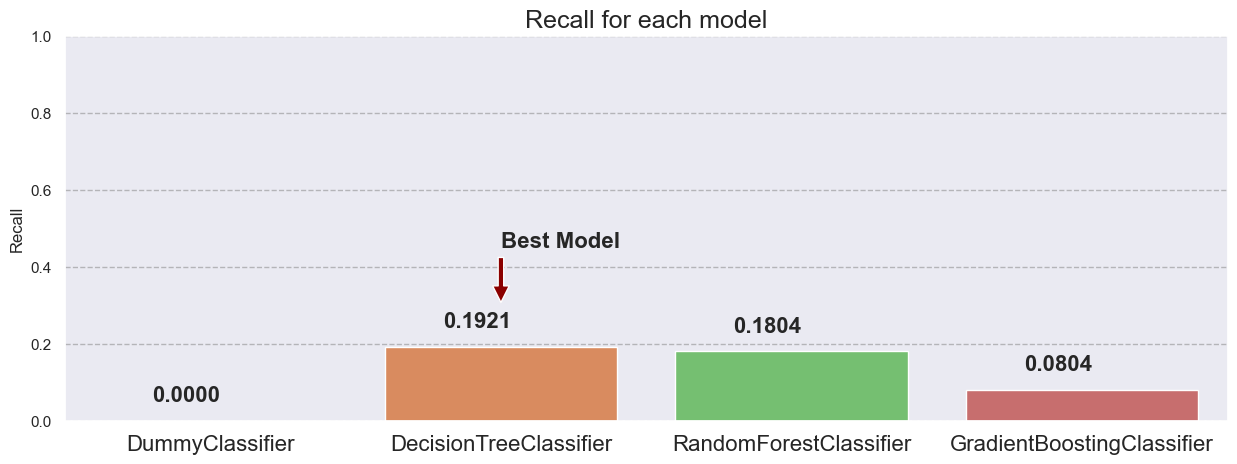

In [157]:
# Plot Recall
plt.figure(figsize=(15, 5))
sns.barplot(x='model', y='Recall', data=scores, palette='muted')
plt.ylabel('Recall')
plt.title('Recall for each model', fontsize=18)
# hide x axis header
plt.xlabel('')
plt.xticks(rotation=0, fontsize=16)
plt.ylim(0, 1)
grid = plt.grid(axis='y', linestyle='--', alpha=0.5, color = 'gray')
# show values on top of bars
for i, v in enumerate(scores['Recall']):
    plt.text(i - 0.2, v + 0.05, f'{v:.4f}', fontsize=16, fontweight='bold')
# Show an arrow pointing to the best model
plt.annotate('Best Model', xy=(1, 0.3), xytext=(1, 0.45), fontsize=16, fontweight='bold', arrowprops=dict(facecolor='darkred', shrink=0.05))
plt.savefig('Recall.png', dpi=300, bbox_inches='tight');

### Decision tree classification

In [159]:
# A simple decision tree to classify HCSG KPIs and make recommendations
dtree = DecisionTreeClassifier()
start = time.time()
dtree.fit(X_train, y_train)
y_pred = dtree.predict(X_test)
end = time.time()

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(f'Time to train: {end - start:.2f} seconds')

              precision    recall  f1-score   support

           0       0.98      0.99      0.99    258669
           1       0.42      0.19      0.27      7023

    accuracy                           0.97    265692
   macro avg       0.70      0.59      0.63    265692
weighted avg       0.96      0.97      0.97    265692

[[256824   1845]
 [  5661   1362]]
Time to train: 15.87 seconds


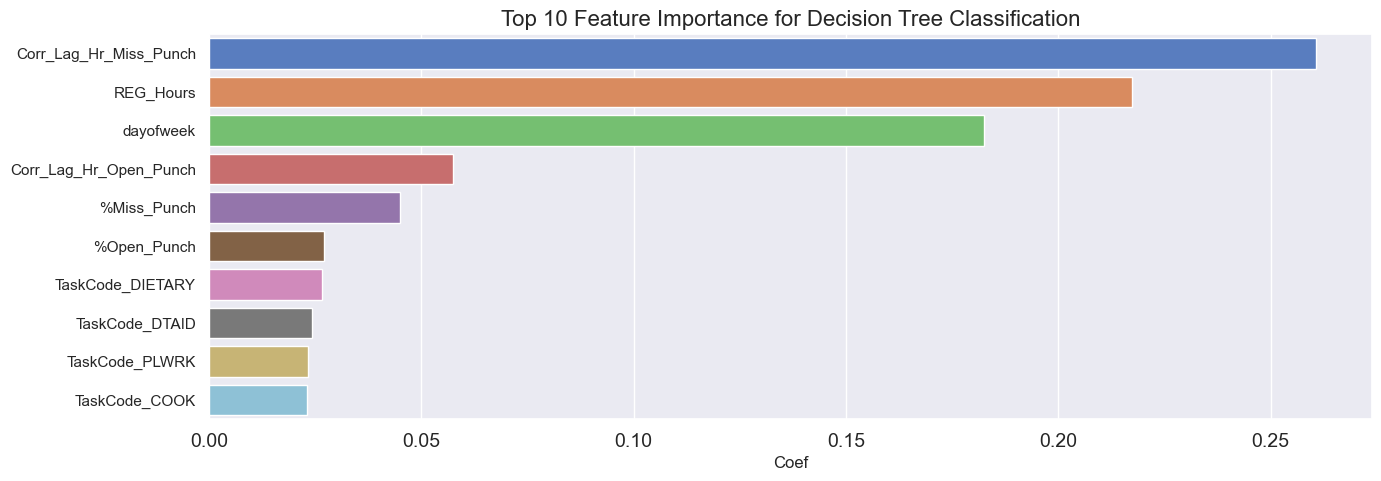

In [162]:
# Plot Decision Tree feature importance
CC = pd.DataFrame({'Feature': X_train.columns, 'Coef': dtree.feature_importances_})
CC = CC.sort_values('Coef', ascending=False)
plt.figure(figsize=(15, 5))
sns.barplot(y='Feature', x='Coef', data=CC.head(10), palette='muted', orient='h')
plt.ylabel('')
plt.title('Top 10 Feature Importance for Decision Tree Classification', fontsize=16)
plt.xticks(rotation=0, fontsize=14)
plt.savefig('Decision Tree Classification Feature Importance.png', dpi=300, bbox_inches='tight');

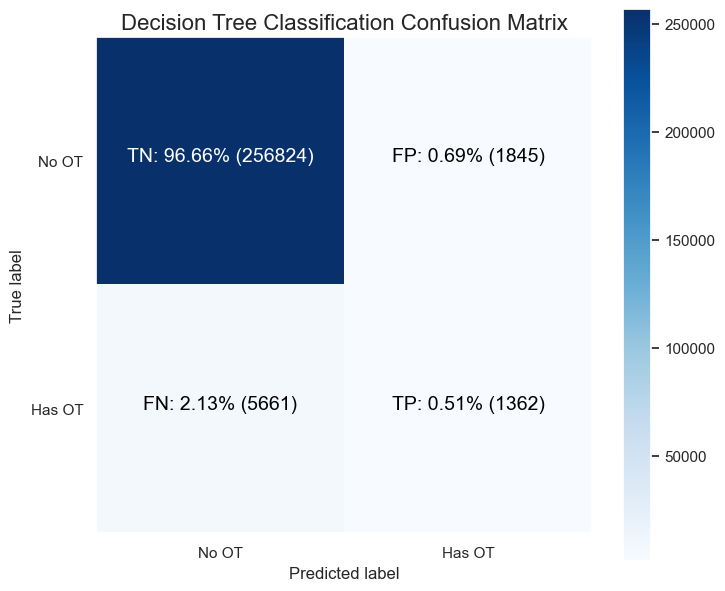

In [164]:
# Plot Decision Tree confusion matri
df_preds = dtree.predict(X_test)
df_confusion_mat  = confusion_matrix(y_test, df_preds, labels=dtree.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=df_confusion_mat ,display_labels = ['No OT', 'Has OT'])
# disp.plot(cmap='Blues', values_format='d', xticks_rotation='horizontal')
plt.rcParams['figure.figsize'] = (8, 8)
disp.plot(cmap='Blues', values_format='d', xticks_rotation='horizontal', include_values=False)
plt.grid(False)
#Show values and percentages
plt.text(0, 0, f'TN: {round(df_confusion_mat[0][0]/len(y_test)*100,2)}% ({df_confusion_mat[0][0]})', ha='center', fontsize=14, color='white')
plt.text(0, 1, f'FN: {round(df_confusion_mat[1][0]/len(y_test)*100,2)}% ({df_confusion_mat[1][0]})', ha='center', fontsize=14, color='black')
plt.text(1, 0, f'FP: {round(df_confusion_mat[0][1]/len(y_test)*100,2)}% ({df_confusion_mat[0][1]})', ha='center', fontsize=14, color='black')
plt.text(1, 1, f'TP: {round(df_confusion_mat[1][1]/len(y_test)*100,2)}% ({df_confusion_mat[1][1]})', ha='center', fontsize=14, color='black')
plt.subplots_adjust(top=0.8)
plt.title('Decision Tree Classification Confusion Matrix', fontsize=16);
plt.savefig('Decision Tree confusion_matrix.png', bbox_inches='tight');

<div class="alert alert-info" role="alert">

  # Classification Model Tuning and Optimization

</div>

In [167]:
# Hyperparameter tuning for Decsion Tree Classifier
# Create the parameter grid based on the results of random search
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [2, 10, 50, 100, 250],
    'min_samples_leaf': [1, 5, 10],
    'min_samples_split': [2,  5, 10]
}

# instantiate the model
dtree = DecisionTreeClassifier()
# instantiate the grid search model
dtree_cv = GridSearchCV(estimator = dtree, param_grid = param_grid,
                            cv = 5, n_jobs = -1, verbose = 2)

# fit the grid search to the data
dtree_cv.fit(X_train, y_train)

print("Tuned Decision Tree Parameters: {}".format(dtree_cv.best_params_))
print("Best score is {}".format(dtree_cv.best_score_))
print('Training Accuracy score: {:.3f}'.format(dtree_cv.score(X_train, y_train)))
print('Test Accuracy score: {:.3f}'.format(dtree_cv.score(X_test, y_test)))
print('Average fit time: {:.3f}'.format(dtree_cv.cv_results_['mean_fit_time'].mean()))

# print confusion matrix
y_pred = dtree_cv.predict(X_test)
print(confusion_matrix(y_test, y_pred))

df_accuracy = accuracy_score(y_test, y_pred)
df_precision = precision_score(y_test, y_pred, average='weighted')
df_recall = recall_score(y_test, y_pred, average='weighted')

print('Accuracy: {:.4f}'.format(df_accuracy))
print('Precision: {:.4f}'.format(df_precision))
print('Recall: {:.4f}'.format(df_recall))
# %timeit dtree_cv.fit(X_train, y_train)
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 90 candidates, totalling 450 fits


Tuned Decision Tree Parameters: {'criterion': 'entropy', 'max_depth': 50, 'min_samples_leaf': 10, 'min_samples_split': 5}
Best score is 0.9749090645137877
Training Accuracy score: 0.976
Test Accuracy score: 0.975
Average fit time: 25.942
[[257930    739]
 [  5865   1158]]
Accuracy: 0.975
Precision: 0.968
Recall: 0.975
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    258669
           1       0.61      0.16      0.26      7023

    accuracy                           0.98    265692
   macro avg       0.79      0.58      0.62    265692
weighted avg       0.97      0.98      0.97    265692



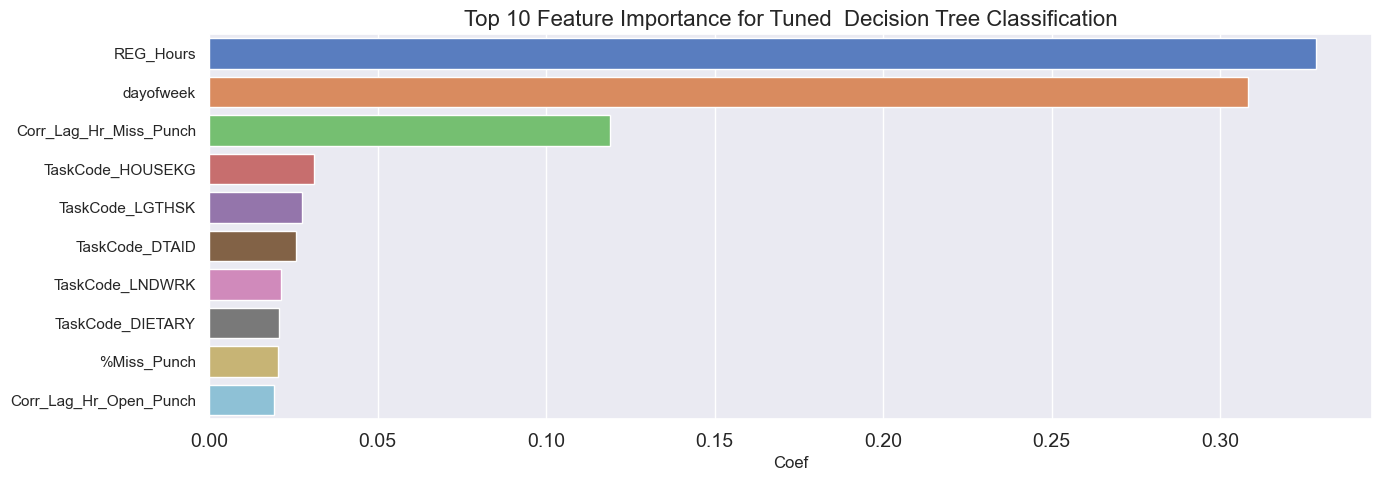

In [169]:
# Plot Decision Tree feature importance
CC = pd.DataFrame({'Feature': X_train.columns, 'Coef': dtree_cv.best_estimator_.feature_importances_})
CC = CC.sort_values('Coef', ascending=False)
plt.figure(figsize=(15, 5))
sns.barplot(y='Feature', x='Coef', data=CC.head(10), palette='muted', orient='h')
plt.ylabel('')
plt.title('Top 10 Feature Importance for Tuned  Decision Tree Classification', fontsize=16)
plt.xticks(rotation=0, fontsize=14)
plt.savefig('Tuned Decision Tree Classification Feature Importance.png', dpi=300, bbox_inches='tight');

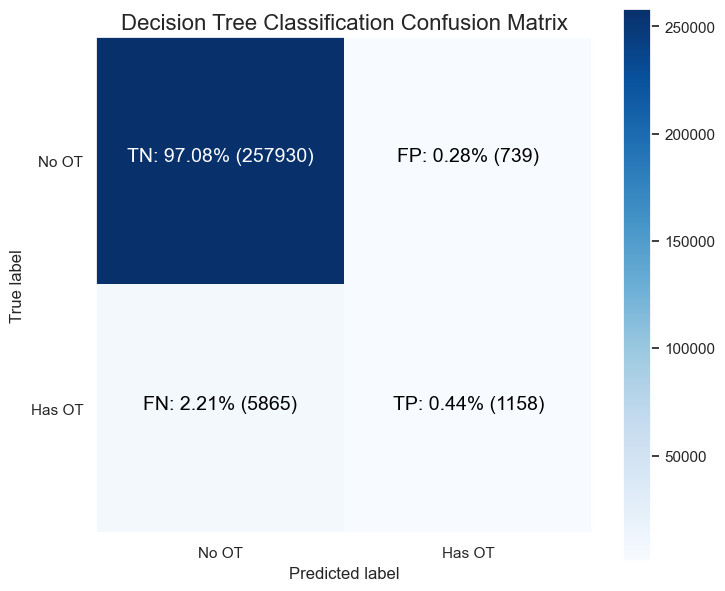

In [171]:
# Plot Tuned Decision Tree confusion matrix
df_preds = dtree_cv.predict(X_test)
df_confusion_mat  = confusion_matrix(y_test, df_preds, labels=dtree_cv.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=df_confusion_mat ,display_labels = ['No OT', 'Has OT'])
# disp.plot(cmap='Blues', values_format='d', xticks_rotation='horizontal')
plt.rcParams['figure.figsize'] = (8, 8)
disp.plot(cmap='Blues', values_format='d', xticks_rotation='horizontal', include_values=False)
plt.grid(False)
#Show values and percentages
plt.text(0, 0, f'TN: {round(df_confusion_mat[0][0]/len(y_test)*100,2)}% ({df_confusion_mat[0][0]})', ha='center', fontsize=14, color='white')
plt.text(0, 1, f'FN: {round(df_confusion_mat[1][0]/len(y_test)*100,2)}% ({df_confusion_mat[1][0]})', ha='center', fontsize=14, color='black')
plt.text(1, 0, f'FP: {round(df_confusion_mat[0][1]/len(y_test)*100,2)}% ({df_confusion_mat[0][1]})', ha='center', fontsize=14, color='black')
plt.text(1, 1, f'TP: {round(df_confusion_mat[1][1]/len(y_test)*100,2)}% ({df_confusion_mat[1][1]})', ha='center', fontsize=14, color='black')
plt.subplots_adjust(top=0.8)
plt.title('Tuned Decision Tree Classification Confusion Matrix', fontsize=16);
plt.savefig('Tuned Decision Tree confusion_matrix.png', bbox_inches='tight');

In [178]:
scores.head()

model  Accuracy Precision    Recall  \
0             DummyClassifier  0.973567       0.0       0.0   
1      DecisionTreeClassifier  0.971794  0.425686  0.192083   
2      RandomForestClassifier  0.973887  0.517354  0.180407   
3  GradientBoostingClassifier  0.974553  0.650922   0.08045   
4         Tuned Decision Tree  0.975144  0.968057  0.975144   

  Time to Train (sec)  
0            0.074873  
1            9.555125  
2          290.028239  
3          215.176322  
4                1541

In [175]:
scores.loc[4] = ['Tuned Decision Tree', '0.975144', '0.968057', '0.975144', '1541']

In [180]:
scores.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5 entries, 0 to 4
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   model                5 non-null      object
 1   Accuracy             5 non-null      object
 2   Precision            5 non-null      object
 3   Recall               5 non-null      object
 4   Time to Train (sec)  5 non-null      object
dtypes: object(5)
memory usage: 240.0+ bytes


In [181]:
# Convert Accuracy, Precision, Recall and Time to Train (sec) to float
scores['Accuracy'] = scores['Accuracy'].astype('float')
scores['Precision'] = scores['Precision'].astype('float')
scores['Recall'] = scores['Recall'].astype('float')
scores['Time to Train (sec)'] = scores['Time to Train (sec)'].astype('float')


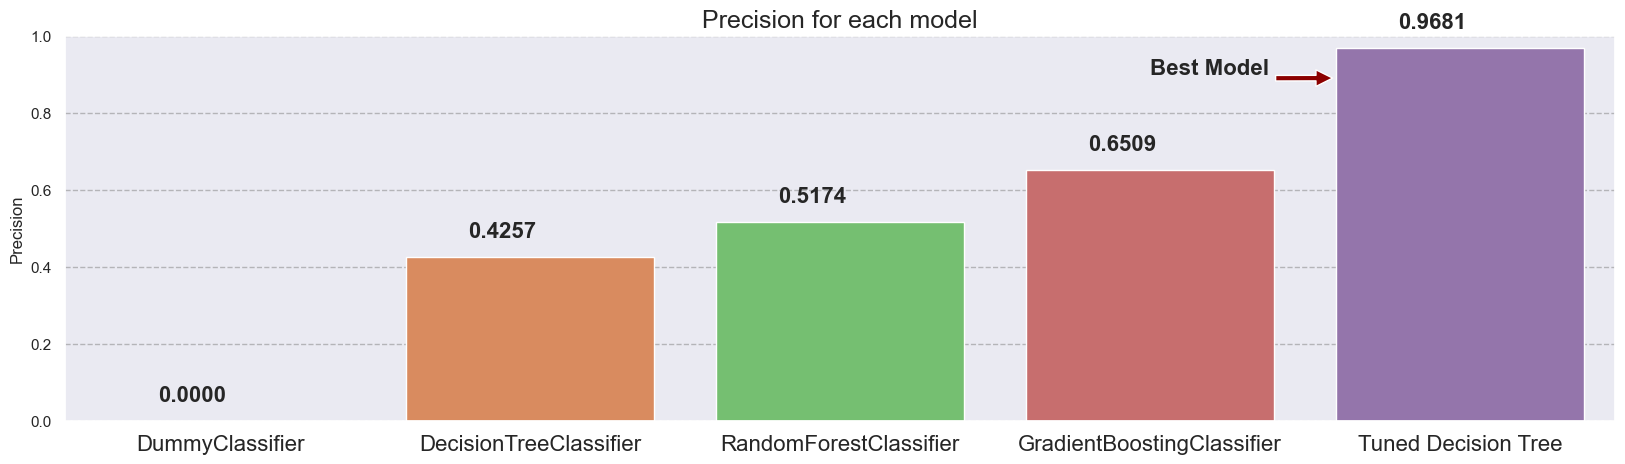

In [188]:
# Plot Precision
plt.figure(figsize=(20, 5))
sns.barplot(x='model', y='Precision', data=scores, palette='muted')
plt.ylabel('Precision')
plt.title('Precision for each model', fontsize=18)
# hide x axis header
plt.xlabel('')
plt.xticks(rotation=0, fontsize=16)
plt.ylim(0, 1)
grid = plt.grid(axis='y', linestyle='--', alpha=0.5, color = 'gray')
# show values on top of bars
for i, v in enumerate(scores['Precision']):
    plt.text(i - 0.2, v + 0.05, f'{v:.4f}', fontsize=16, fontweight='bold')
# Show an arrow pointing to the best model
plt.annotate('Best Model', xy=(3.6, 0.89), xytext=(3, 0.9), fontsize=16, fontweight='bold', arrowprops=dict(facecolor='darkred', shrink=0.05))
plt.savefig('Precision.png', dpi=300, bbox_inches='tight');

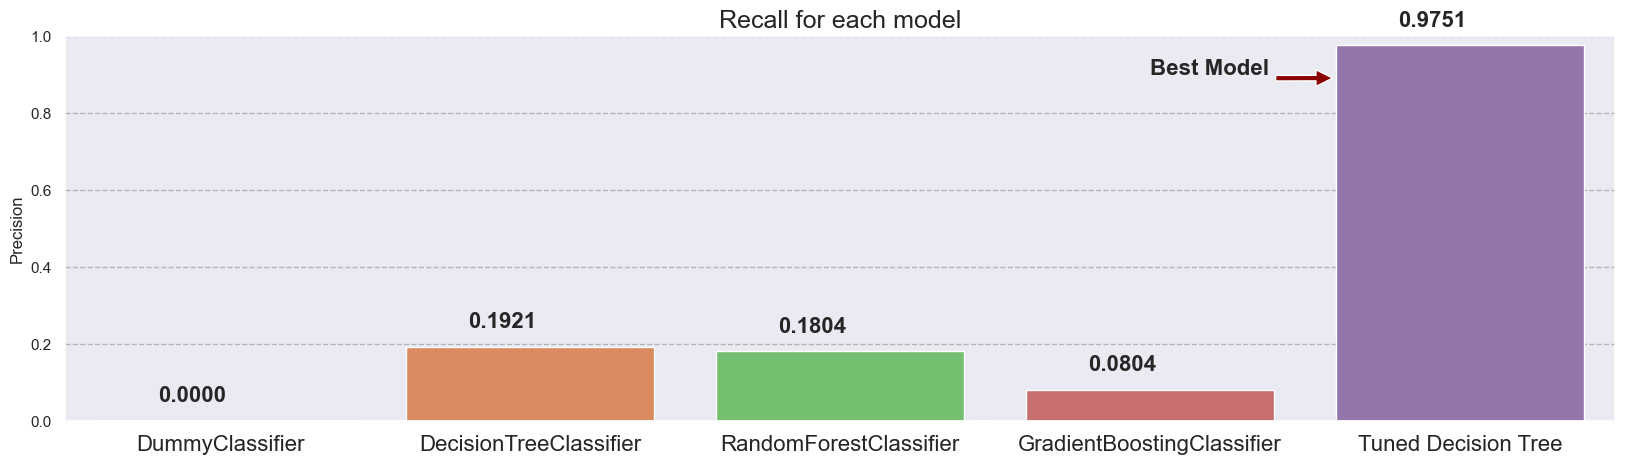

In [189]:
# Plot Recall
plt.figure(figsize=(20, 5))
sns.barplot(x='model', y='Recall', data=scores, palette='muted')
plt.ylabel('Precision')
plt.title('Recall for each model', fontsize=18)
# hide x axis header
plt.xlabel('')
plt.xticks(rotation=0, fontsize=16)
plt.ylim(0, 1)
grid = plt.grid(axis='y', linestyle='--', alpha=0.5, color = 'gray')
# show values on top of bars
for i, v in enumerate(scores['Recall']):
    plt.text(i - 0.2, v + 0.05, f'{v:.4f}', fontsize=16, fontweight='bold')
# Show an arrow pointing to the best model
plt.annotate('Best Model', xy=(3.6, 0.89), xytext=(3, 0.9), fontsize=16, fontweight='bold', arrowprops=dict(facecolor='darkred', shrink=0.05))
plt.savefig('Recall.png', dpi=300, bbox_inches='tight');